### Import required Python libraries and set plotting parameters 


In [1]:
!spack find -p tfel

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
==> 1 installed package


In [2]:
%env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

env: LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib


In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import time
import os
import os.path
import zipfile
import pandas as pd
from scipy.optimize import curve_fit, least_squares
import sys
import gmsh
import math
import pyvista as pv
import re

from matplotlib.colors import ListedColormap
pv.set_plot_theme("document")

plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = "DejaVu Serif"
plt.rcParams['font.size'] = 20

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(800, 600))
display.start()
    
user_name=!whoami # get user name
user_name=user_name[0]
um_view = "/mofem_install/jupyter/%s/um_view_release" % user_name
#um_view = "/mofem_install/jupyter/callum/mofem_install/mofem-cephas/mofem/users_modules/um-build-Release-7q7t4mo"

### Define utility functions including black-box launch of MoFEM


In [5]:
class AttrDict(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        raise AttributeError(f"'AttrDict' object has no attribute '{attr}'")
    def __setattr__(self, key, value):
        self[key] = value
        
def replace_template_sdf(params):
    regex = r"\{(.*?)\}"
    with open(params.template_sdf_file) as infile, open(params.sdf_file, 'w') as outfile:
        for line in infile:
            matches = re.finditer(regex, line, re.DOTALL)
            for match in matches:
                for name in match.groups():
                    src = "{" + name + "}"
                    target = str(params[name])
                    line = line.replace(src, target)
            outfile.write(line)

def get_young_modulus(K, G):
    E = 9. * K * G /(3. * K + G)
    return E

def get_poisson_ratio(K, G):
    nu = (3. * K - 2. * G) / 2. / (3. * K + G)
    return nu

def get_bulk_modulus(E, nu):
    K = E / 3. / (1. - 2. * nu)
    return K

def get_shear_modulus(E, nu):
    G = E / 2. / (1. + nu)
    return G

def parse_log_file(filepath):
    force, time, area = [], [], []
    with open(filepath, "r") as log_file:
        for line in log_file:
            line = line.strip()
            if "Contact force:" in line:
                line = line.split()
                time.append(float(line[6]))
                force.append(float(line[10]))
            if "Contact area:" in line:
                line = line.split()
                area.append(float(line[8]))
    return time, force, area

def generate_config(params):
    with open(params.config_file, 'w') as f:
        data = [f"[block_2]", f"id={params.mfront_block_id}", "add=BLOCKSET", f"name=MFRONT_MAT_{params.mfront_block_id}"]
        for line in data:
            f.write(line + '\n')
    return

def mofem_compute_force_indent(params):
    !rm -rf out*
    
    mi_param_2 = 0
    mi_param_3 = 0
    mi_param_4 = 0
    
    if params.material_model == "LinearElasticity":
        mi_block = "LinearElasticity"
        mi_param_0 = params.young_modulus
        mi_param_1 = params.poisson_ratio
    elif params.material_model == "SaintVenantKirchhoffElasticity":
        mi_block = "SaintVenantKirchhoffElasticity"
        mi_param_0 = params.young_modulus
        mi_param_1 = params.poisson_ratio
    elif params.material_model == "NeoHookeanHyperElasticity":
        mi_block = "SignoriniHyperElasticity"
        mi_param_0 = get_bulk_modulus(params.young_modulus, params.poisson_ratio)
        mi_param_1 = 0.5 * get_shear_modulus(params.young_modulus, params.poisson_ratio)
    elif params.material_model == "StandardLinearSolid":
        mi_block = "StandardLinearSolid"
        mi_param_0 = get_bulk_modulus(params.young_modulus_0, params.poisson_ratio_0)
        mi_param_1 = get_shear_modulus(params.young_modulus_0, params.poisson_ratio_0)
        mi_param_2 = get_bulk_modulus(params.young_modulus_1, params.poisson_ratio_1)
        mi_param_3 = get_shear_modulus(params.young_modulus_1, params.poisson_ratio_1)
        mi_param_4 = params.relax_time_1
    else:
        print("Unknown material model: " + params.material_model)
        return
        
    replace_template_sdf(params)
        
    !export OMPI_MCA_btl_vader_single_copy_mechanism=none && \
    nice -n 10 mpirun --oversubscribe --allow-run-as-root \
    -np {params.nproc} {um_view}/tutorials/adv-1/contact_2d \
    -file_name {params.part_file} \
    -sdf_file {params.sdf_file} \
    -order {params.order} \
    -ts_dt {params.time_step} \
    -ts_max_time {params.final_time} \
    -mi_lib_path_{params.mfront_block_id} {um_view}/mfront_interface/libBehaviour.so \
    -mi_block_{params.mfront_block_id} {mi_block} \
    -mi_param_{params.mfront_block_id}_0 {mi_param_0} \
    -mi_param_{params.mfront_block_id}_1 {mi_param_1} \
    -mi_param_{params.mfront_block_id}_2 {mi_param_2} \
    -mi_param_{params.mfront_block_id}_3 {mi_param_3} \
    -mi_param_{params.mfront_block_id}_4 {mi_param_4} \
    -mi_save_volume 1 \
    -mi_save_gauss 0 \
    2>&1 | tee {params.log_file}

    time, react, area = parse_log_file(params.log_file)
    indent = np.asarray(time) * (params.max_indentation / params.final_time)
    force = np.asarray(react)
    
    return indent, force, area

def show_results(params):
    out_to_vtk = !ls -c1 out_*h5m
    last_file=out_to_vtk[0]
    print(last_file)
    !mbconvert {last_file} {last_file[:-3]}vtk
    
    import pyvista as pv
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.image as mpimg
    import re, os

    mesh = pv.read(last_file[:-3] + "vtk")

    mesh=mesh.warp_by_vector('DISPLACEMENT', factor=1)
    if params.show_edges:
        mesh=mesh.shrink(0.95)
    
    if params.show_field == "DISPLACEMENT" or params.show_field == "displacement":
        field = "DISPLACEMENT"
        if params.show_component == "X" or params.show_component == 'x':
            comp = 0
        elif params.show_component == "Y" or params.show_component == 'y':
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return
        
    if params.show_field == "STRESS" or params.show_field == "stress":
        field = "STRESS"
        if params.show_component == "X" or params.show_component == "x":
            comp = 0
        elif params.show_component == "Y" or params.show_component == "y":
            comp = 4
        elif params.show_component == "XY" or params.show_component == "xy":
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return

    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=field, component=comp, show_edges=True, smooth_shading=False, cmap="turbo")
    
    circle = pv.Circle(radius=params.indenter_radius, resolution=1000)
    circle = circle.translate((0, params.indenter_radius - params.max_indentation, 0), inplace=False)
    p.add_mesh(circle, color="grey")
    
    p.camera_position = "xy"
    p.show(jupyter_backend='ipygany')


def generate_mesh(params):
    gmsh.initialize()
    gmsh.model.add("Nanoindentation")
    
    a = params.refine_radius    
    H = params.mesh_height 
    L = params.mesh_length
    R = params.indenter_radius
    
    # Creating points
    tol = 1e-3
    
    print(a, H, R)
    
    if a < H / 2 and H > R:
        point1 = gmsh.model.geo.addPoint(0, 0, 0, tol)
        point2 = gmsh.model.geo.addPoint(0, -a, 0, tol)
        point3 = gmsh.model.geo.addPoint(a, 0, 0, tol)
        point4 = gmsh.model.geo.addPoint(0, -H, 0, tol)
        point5 = gmsh.model.geo.addPoint(L, -H, 0, tol)
        point6 = gmsh.model.geo.addPoint(L, 0, 0, tol)

        # Creating connection lines
        arc1 = gmsh.model.geo.addCircleArc(point3, point1, point2)
        line1 = gmsh.model.geo.addLine(point1, point2)
        line2 = gmsh.model.geo.addLine(point2, point4)
        line3 = gmsh.model.geo.addLine(point4, point5)
        line4 = gmsh.model.geo.addLine(point5, point6)
        line5 = gmsh.model.geo.addLine(point6, point3)
        line6 = gmsh.model.geo.addLine(point3, point1)

        loop1 = gmsh.model.geo.addCurveLoop([line1, -arc1, line6])
        surface1 = gmsh.model.geo.addPlaneSurface([loop1])

        loop2 = gmsh.model.geo.addCurveLoop([arc1, line2, line3, line4, line5])
        surface2 = gmsh.model.geo.addPlaneSurface([loop2])

        # This command is mandatory and synchronize CAD with GMSH Model. The less you launch it, the better it is for performance purpose
        gmsh.model.geo.synchronize()

        domain = gmsh.model.addPhysicalGroup(2, [surface1, surface2])
        gmsh.model.setPhysicalName(2, domain, '!_DOMAIN')
        contact = gmsh.model.addPhysicalGroup(1, [line5, line6])
        gmsh.model.setPhysicalName(1, contact, 'CONTACT')
        fix_x = gmsh.model.addPhysicalGroup(1, [line1, line2])
        gmsh.model.setPhysicalName(1, fix_x, 'FIX_X')
        fix_y = gmsh.model.addPhysicalGroup(1, [line3])
        gmsh.model.setPhysicalName(1, fix_y, 'FIX_Y')
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -H, 0, L, 0, 0), params.far_field_size)
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -a, 0, a, 0, 0), params.near_field_size)
    else:
        point1 = gmsh.model.geo.addPoint(0, 0, 0, tol)
        point2 = gmsh.model.geo.addPoint(0, -H, 0, tol)
        point3 = gmsh.model.geo.addPoint(H, -H, 0, tol)
        point4 = gmsh.model.geo.addPoint(H, 0, 0, tol)
        point5 = gmsh.model.geo.addPoint(L, -H, 0, tol)
        point6 = gmsh.model.geo.addPoint(L, 0, 0, tol)

        # Creating connection lines
        line1 = gmsh.model.geo.addLine(point1, point2)
        line2 = gmsh.model.geo.addLine(point2, point3)
        line3 = gmsh.model.geo.addLine(point3, point4)
        line4 = gmsh.model.geo.addLine(point4, point1)
        line5 = gmsh.model.geo.addLine(point3, point5)
        line6 = gmsh.model.geo.addLine(point5, point6)
        line7 = gmsh.model.geo.addLine(point6, point4)

        loop1 = gmsh.model.geo.addCurveLoop([line1, line2, line3, line4])
        surface1 = gmsh.model.geo.addPlaneSurface([loop1])

        loop2 = gmsh.model.geo.addCurveLoop([-line3, line5, line6, line7])
        surface2 = gmsh.model.geo.addPlaneSurface([loop2])

        # This command is mandatory and synchronize CAD with GMSH Model. The less you launch it, the better it is for performance purpose
        gmsh.model.geo.synchronize()

        domain = gmsh.model.addPhysicalGroup(2, [surface1, surface2])
        gmsh.model.setPhysicalName(2, domain, '!_DOMAIN')
        contact = gmsh.model.addPhysicalGroup(1, [line7, line4])
        gmsh.model.setPhysicalName(1, contact, 'CONTACT')
        fix_x = gmsh.model.addPhysicalGroup(1, [line1])
        gmsh.model.setPhysicalName(1, fix_x, 'FIX_X')
        fix_y = gmsh.model.addPhysicalGroup(1, [line2, line5])
        gmsh.model.setPhysicalName(1, fix_y, 'FIX_Y1')
        
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -H, 0, L, 0, 0), params.far_field_size)
        gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -H, 0, H, 0, 0), params.near_field_size)
        
    gmsh.model.mesh.generate(2)    

    # Save mesh
    gmsh.write(params.med_file)

    # Finalize GMSH = END OF CODE=
    gmsh.finalize()
    
    generate_config(params)
    
    !read_med -med_file {params.med_file} -output_file {params.mesh_file} -meshsets_config {params.config_file} -log_sl inform
    
    params.part_file = os.path.splitext(params.mesh_file)[0] + "_" + str(params.nproc) + "p.h5m"
    #partition the mesh into nproc parts
    !{um_view}/bin/mofem_part \
    -my_file {params.mesh_file} \
    -my_nparts {params.nproc} \
    -output_file {params.part_file} \
    -dim 2 -adj_dim 1
    
    if params.show_mesh:
        !mbconvert {params.mesh_file} {params.vtk_file}

        mesh = pv.read(params.vtk_file )
        mesh = mesh.shrink(0.95)

        p = pv.Plotter(notebook=True)
        p.add_mesh(mesh, smooth_shading=False)

        circle = pv.Circle(radius=params.indenter_radius, resolution=1000)
        circle = circle.translate((0, params.indenter_radius, 0), inplace=False)

        p.add_mesh(circle, color="grey")
        p.camera_position = "xy"
        p.show(jupyter_backend='ipygany')
    
    return

def hertz_press(indent, params):   
    Es = params.young_modulus / (1 - params.poisson_ratio**2)    
    return 4./3. * Es * np.sqrt(params.indenter_radius) * pow(indent, 3./2.)

def hertz_area(indent, params):   
    return np.pi * indent * params.indenter_radius


### Sketch of the problem setup

<!-- 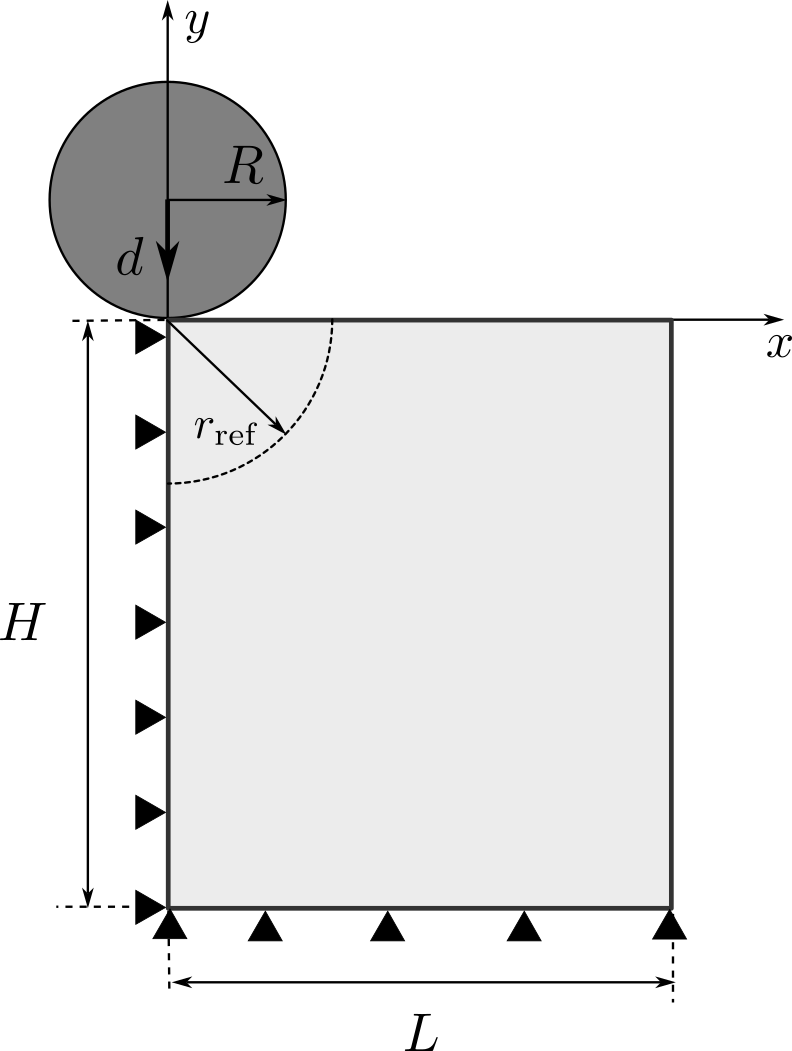 -->

<div>
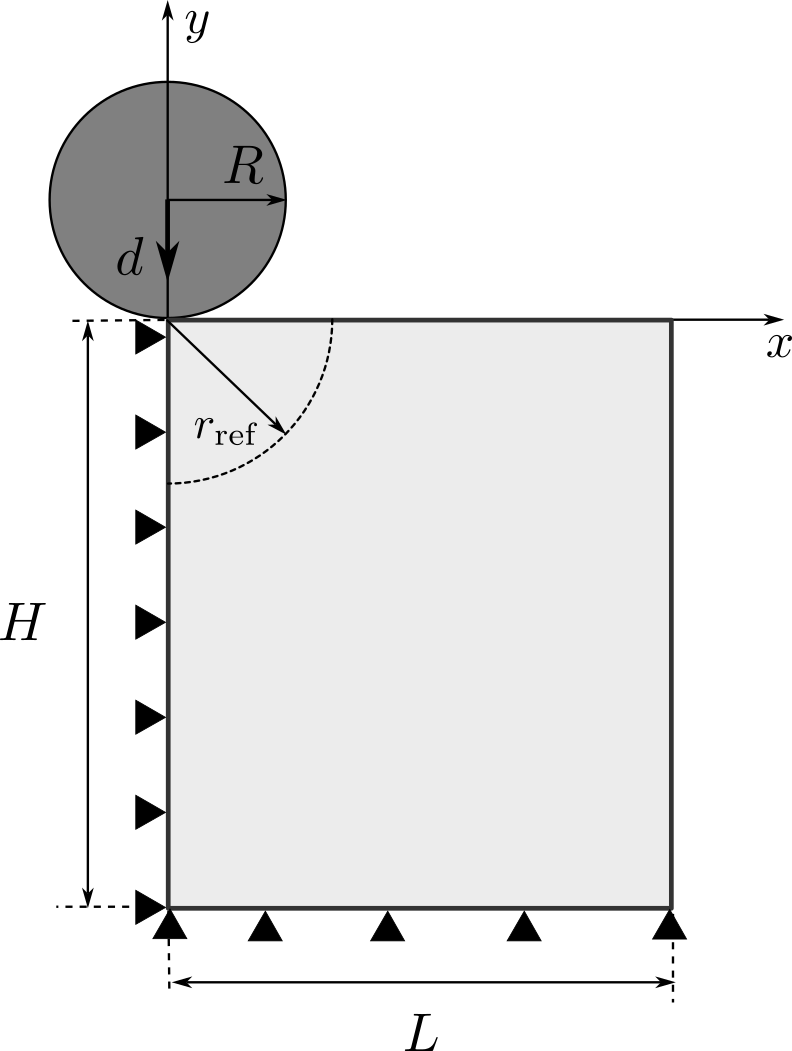
</div>

### Set simulation parameters

In [6]:
params = AttrDict()

params.med_file = "mesh_2d.med"
params.mesh_file = "mesh_2d.h5m"
params.vtk_file = "mesh_2d.vtk"

params.load_hist = "load.txt"
params.log_file = "log_indent"

params.template_sdf_file = "template_sdf.py"
params.sdf_file = "sdf.py"

params.config_file = "bc.cfg"
params.mfront_block_id = 10

params.nproc = 8 # number of processors/cores used
params.order = 2 #order of approximation functions

params.final_time = 1 # [s]
params.time_step = 0.05 # [s]

params.indenter_radius = 10 
params.max_indentation = 1
params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 50 # L
params.mesh_height = params.mesh_length * 2    # H

params.far_field_size = params.mesh_height / 10
params.near_field_size = params.refine_radius / 10

### Generate and visualise the mesh

In [7]:
params.show_mesh = True
generate_mesh(params)

3.1622776601683795 316.22776601683796 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00751538s, CPU 0.007638s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00990563s, CPU 0.009352s)
Info    : 574 nodes 1168 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:12:57
[0] <inform> UTC time: 2024-7-27 15:12:57
[0] <inform> [MED] Reading MED file 

Scene(background_color='#ffffff', camera={'position': [73.89604949951172, -148.11387634277344, 362.96620127851…

### Convergence w.r.t. number of elements per side

In [8]:
elem_num_list = [2, 5, 10, 20]
indent_list = []
force_list = []

params.young_modulus = 100
params.poisson_ratio = 0.45
params.material_model = "LinearElasticity"
params.show_mesh = False

for elem_num in elem_num_list:
    params.far_field_size = params.mesh_height / elem_num
    params.near_field_size = params.refine_radius / elem_num
    generate_mesh(params)
    
    indent, force, area = mofem_compute_force_indent(params)
    indent_list.append(indent)
    force_list.append(force)

3.1622776601683795 316.22776601683796 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00465795s, CPU 0.004982s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00141992s, CPU 0.001438s)
Info    : 83 nodes 174 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:12:59
[0] <inform> UTC time: 2024-7-27 15:12:59
[0] <inform> [MED] Reading MED file V4

[0] <inform> [petsc] MFront material model: AXISYMMETRICAL 
[0] <inform> [petsc] LinearElasticity behaviour loaded on block 10. 
[0] <inform> [petsc] Small Strain Kinematics 
[0] <inform> [petsc] Internal variables: 
[0] <inform> [petsc] : ElasticStrain
[0] <inform> [petsc] External variables: 
[0] <inform> [petsc] : Temperature
[0] <inform> [petsc] Material properties: 
[0] <inform> [petsc] 0 : YoungModulus = 100.
[0] <inform> [petsc] 1 : PoissonRatio = 0.45
[0] <inform> [petsc] Real parameters: 
[0] <inform> [petsc] 2 : minimal_time_step_scaling_factor
[0] <inform> [petsc] 3 : maximal_time_step_scaling_factor
[0] <inform> [petsc] Integer parameters: 
[0] <inform> [petsc] Unsigned short parameters: 
[0] <inform> [ProblemsManager] Removed DOFs from problem SimpleProblem dofs [622 / 622 (before 622 / 622) global]
[0] <inform> [ProblemsManager] Removed DOFs from problem SimpleProblem dofs [622 / 622 (before 622 / 622) global]
[0] <warning> [BcMng] Expected one attribute on block but have

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 8.6842e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.6099e+02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.0257e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.3975e+03
[0] <inform> [Essential] Total force: 8.6842e+00 7.0257e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -7.7585e+03
[0] <inform> [Indent] Ux time 2.5000e-01 min -1.0932e-02 max 3.1047e-02
[0] <inform> [Indent] Uy time 2.5000e-01 min -2.2783e-01 max 6.9540e-02
[0] <inform> [Indent] Contact force: time 2.500e-01 Fx: -7.453439e+00 Fy: 7.025697e+

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2437e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.9702e+02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.9467e+02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0497e+04
[0] <inform> [Essential] Total force: 2.2437e+01 1.9467e+02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.1494e+04
[0] <inform> [Indent] Ux time 5.5000e-01 min -2.3121e-02 max 7.3986e-02
[0] <inform> [Indent] Uy time 5.5000e-01 min -5.8395e-01 max 1.5522e-01
[0] <inform> [Indent] Contact force: time 5.500e-01 Fx: -2.355033e+01 Fy: 1.946658e+

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.6932e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3100e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.5741e+02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.8163e+04
[0] <inform> [Essential] Total force: 3.6932e+01 4.5741e+02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -5.0473e+04
[0] <inform> [Indent] Ux time 9.0000e-01 min -2.2565e-02 max 8.6427e-02
[0] <inform> [Indent] Uy time 9.0000e-01 min -9.1562e-01 max 1.3137e-01
[0] <inform> [Indent] Contact force: time 9.000e-01 Fx: -8.743936e+01 Fy: 4.574143e+

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 940795ae65ee14ad214aeb702914b97273f9ea80
[0] <inform> Local time: 2024-7-27 15:13:3
[0] <inform> UTC time: 2024-7-27 15:13:3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316750 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316751 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y                          
[0] <inform> [MeshsetMng] meshset in database me

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force: time 0.000e+00 Fx: 0.000000e+00 Fy: 0.000000e+00 Fz:

[0] <inform> [petsc]     0 SNES Function norm 8.402463323512e-02 [  1.605627116404e-12  ,   8.402463323512e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 4.283824029918e-02 [  7.920397217309e-13  ,   4.283824029918e-02  ]
[0] <inform> [petsc]     2 SNES Function norm 1.217787392840e-05 [  8.277666815389e-13  ,   1.217787392840e-05  ]
[0] <inform> [petsc]     3 SNES Function norm 7.941228298741e-13 [  7.826947070485e-13  ,   1.342388337461e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.2        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 5 TS dt 0.05 time 0.25
[0] <inform> [Indent] Write file at time 0.25 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8047e+00 0.0000e+00 0.0000e+0

[0] <inform> [petsc]     1 SNES Function norm 7.397893471536e-02 [  5.840704285778e-12  ,   7.397893471536e-02  ]
[0] <inform> [petsc]     2 SNES Function norm 2.990925235709e-05 [  2.351240065794e-12  ,   2.990925235709e-05  ]
[0] <inform> [petsc]     3 SNES Function norm 2.553637951722e-12 [  2.441769184707e-12  ,   7.475493542870e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   9 accepted t=0.45       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 10 TS dt 0.05 time 0.5
[0] <inform> [Indent] Write file at time 0.5 write step 10
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.9767e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2613e+02
[0] <inform> [Essential] EssentialPreProc<Dis

[0] <inform> [petsc]     0 SNES Function norm 1.185994789032e-01 [  1.242363877540e-11  ,   1.185994789032e-01  ]
[0] <inform> [petsc]     1 SNES Function norm 2.021963131791e-06 [  5.396445531274e-12  ,   2.021963131784e-06  ]
[0] <inform> [petsc]     2 SNES Function norm 5.755430637654e-12 [  5.755425183477e-12  ,   7.923524893390e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  15 accepted t=0.75       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 16 TS dt 0.05 time 0.8
[0] <inform> [Indent] Write file at time 0.8 write step 16
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.0661e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.4972e+02
[0] <inform> [Essential] EssentialPreProc<Dis

3.1622776601683795 316.22776601683796 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00732845s, CPU 0.007072s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00968783s, CPU 0.009676s)
Info    : 574 nodes 1168 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:13:4
[0] <inform> UTC time: 2024-7-27 15:13:4
[0] <inform> [MED] Reading MED file V4

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force: time 0.000e+00 Fx: 0.000000e+00 Fy: 0.000000e+00 Fz:

[0] <inform> [petsc]     2 SNES Function norm 5.467007296772e-08 [  1.505237079979e-12  ,   5.467007294700e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.2        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 5 TS dt 0.05 time 0.25
[0] <inform> [Indent] Write file at time 0.25 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5508e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2793e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.6299e+01 0.0000e+00
[0] <inform> [Essenti

[0] <inform> [petsc]     2 SNES Function norm 3.795213040879e-12 [  3.771524843158e-12  ,   4.233702671462e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step   9 accepted t=0.45       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 10 TS dt 0.05 time 0.5
[0] <inform> [Indent] Write file at time 0.5 write step 10
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.5982e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.5515e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.8617e+02 0.0000e+00
[0] <inform> [Essential] M

[0] <inform> [petsc]     2 SNES Function norm 8.499012258153e-12 [  6.950059567117e-12  ,   4.891817798914e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  14 accepted t=0.7        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 15 TS dt 0.05 time 0.75
[0] <inform> [Indent] Write file at time 0.75 write step 15
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 9.3146e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4208e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.3927e+02 0.0000e+00
[0] <inform> [Essential]

[0] <inform> [petsc]     1 SNES Function norm 8.760129653186e-06 [  1.080554428300e-11  ,   8.760129653179e-06  ]
[0] <inform> [petsc]     2 SNES Function norm 1.117733667839e-11 [  1.117728497734e-11  ,   3.399643327867e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  19 accepted t=0.95       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 20 TS dt 0.05 time 1.
[0] <inform> [Indent] Write file at time 1 write step 20
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3484e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.7752e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.

[0] <inform> [FECore] Number of adjacencies 4464
[0] <inform> [ProblemsManager] SimpleProblem Nb. local dof 2060 by 2060 nb global dofs 15908 by 15908
[1] <inform> [ProblemsManager] SimpleProblem Nb. local dof 1978 by 1978 nb global dofs 15908 by 15908
[2] <inform> [ProblemsManager] SimpleProblem Nb. local dof 1980 by 1980 nb global dofs 15908 by 15908
[3] <inform> [ProblemsManager] SimpleProblem Nb. local dof 1926 by 1926 nb global dofs 15908 by 15908
[4] <inform> [ProblemsManager] SimpleProblem Nb. local dof 1950 by 1950 nb global dofs 15908 by 15908
[5] <inform> [ProblemsManager] SimpleProblem Nb. local dof 1934 by 1934 nb global dofs 15908 by 15908
[6] <inform> [ProblemsManager] SimpleProblem Nb. local dof 2034 by 2034 nb global dofs 15908 by 15908
[7] <inform> [ProblemsManager] SimpleProblem Nb. local dof 2046 by 2046 nb global dofs 15908 by 15908
[0] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 0 by 0 Nb. local dof 2060 by 2060
[1] <inform> [P

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4151e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.1382e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.6685e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7543e+03
[0] <inform> [Essential] Total force: 1.4151e-02 1.6685e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.7547e+03
[0] <inform> [Indent] Ux time 1.0000e-01 min -2.7293e-03 max 1.0534e-02
[0] <inform> [Indent] Uy time 1.0000e-01 min -1.0000e-01 max 4.4698e-03
[0] <inform> [Indent] Contact force: time 1.000e-01 Fx: -9.772667e-01 Fy: 1.668500e+

[0] <inform> [petsc]     1 SNES Function norm 1.272277242378e-02 [  4.368440239474e-12  ,   1.272277242378e-02  ]
[0] <inform> [petsc]     2 SNES Function norm 4.563142913545e-08 [  4.386241458990e-12  ,   4.563142892464e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.3        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 7 TS dt 0.05 time 0.35
[0] <inform> [Indent] Write file at time 0.35 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.7129e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6442e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.000

[0] <inform> [petsc]     1 SNES Function norm 8.491185633119e-05 [  1.015615586723e-11  ,   8.491185633118e-05  ]
[0] <inform> [petsc]     2 SNES Function norm 9.865830316256e-12 [  9.687830008155e-12  ,   1.865625247002e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  11 accepted t=0.55       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 12 TS dt 0.05 time 0.6
[0] <inform> [Indent] Write file at time 0.6 write step 12
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 9.1384e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.8359e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.361526785498e-02 [  1.833097875445e-11  ,   3.361526785498e-02  ]
[0] <inform> [petsc]     2 SNES Function norm 1.003788444846e-03 [  1.640137786115e-11  ,   1.003788444846e-03  ]
[0] <inform> [petsc]     3 SNES Function norm 1.902854333073e-11 [  1.589787913812e-11  ,   1.045671555503e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  16 accepted t=0.8        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 17 TS dt 0.05 time 0.85
[0] <inform> [Indent] Write file at time 0.85 write step 17
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4246e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.7132e+00
[0] <inform> [Essential] EssentialPreProc<D

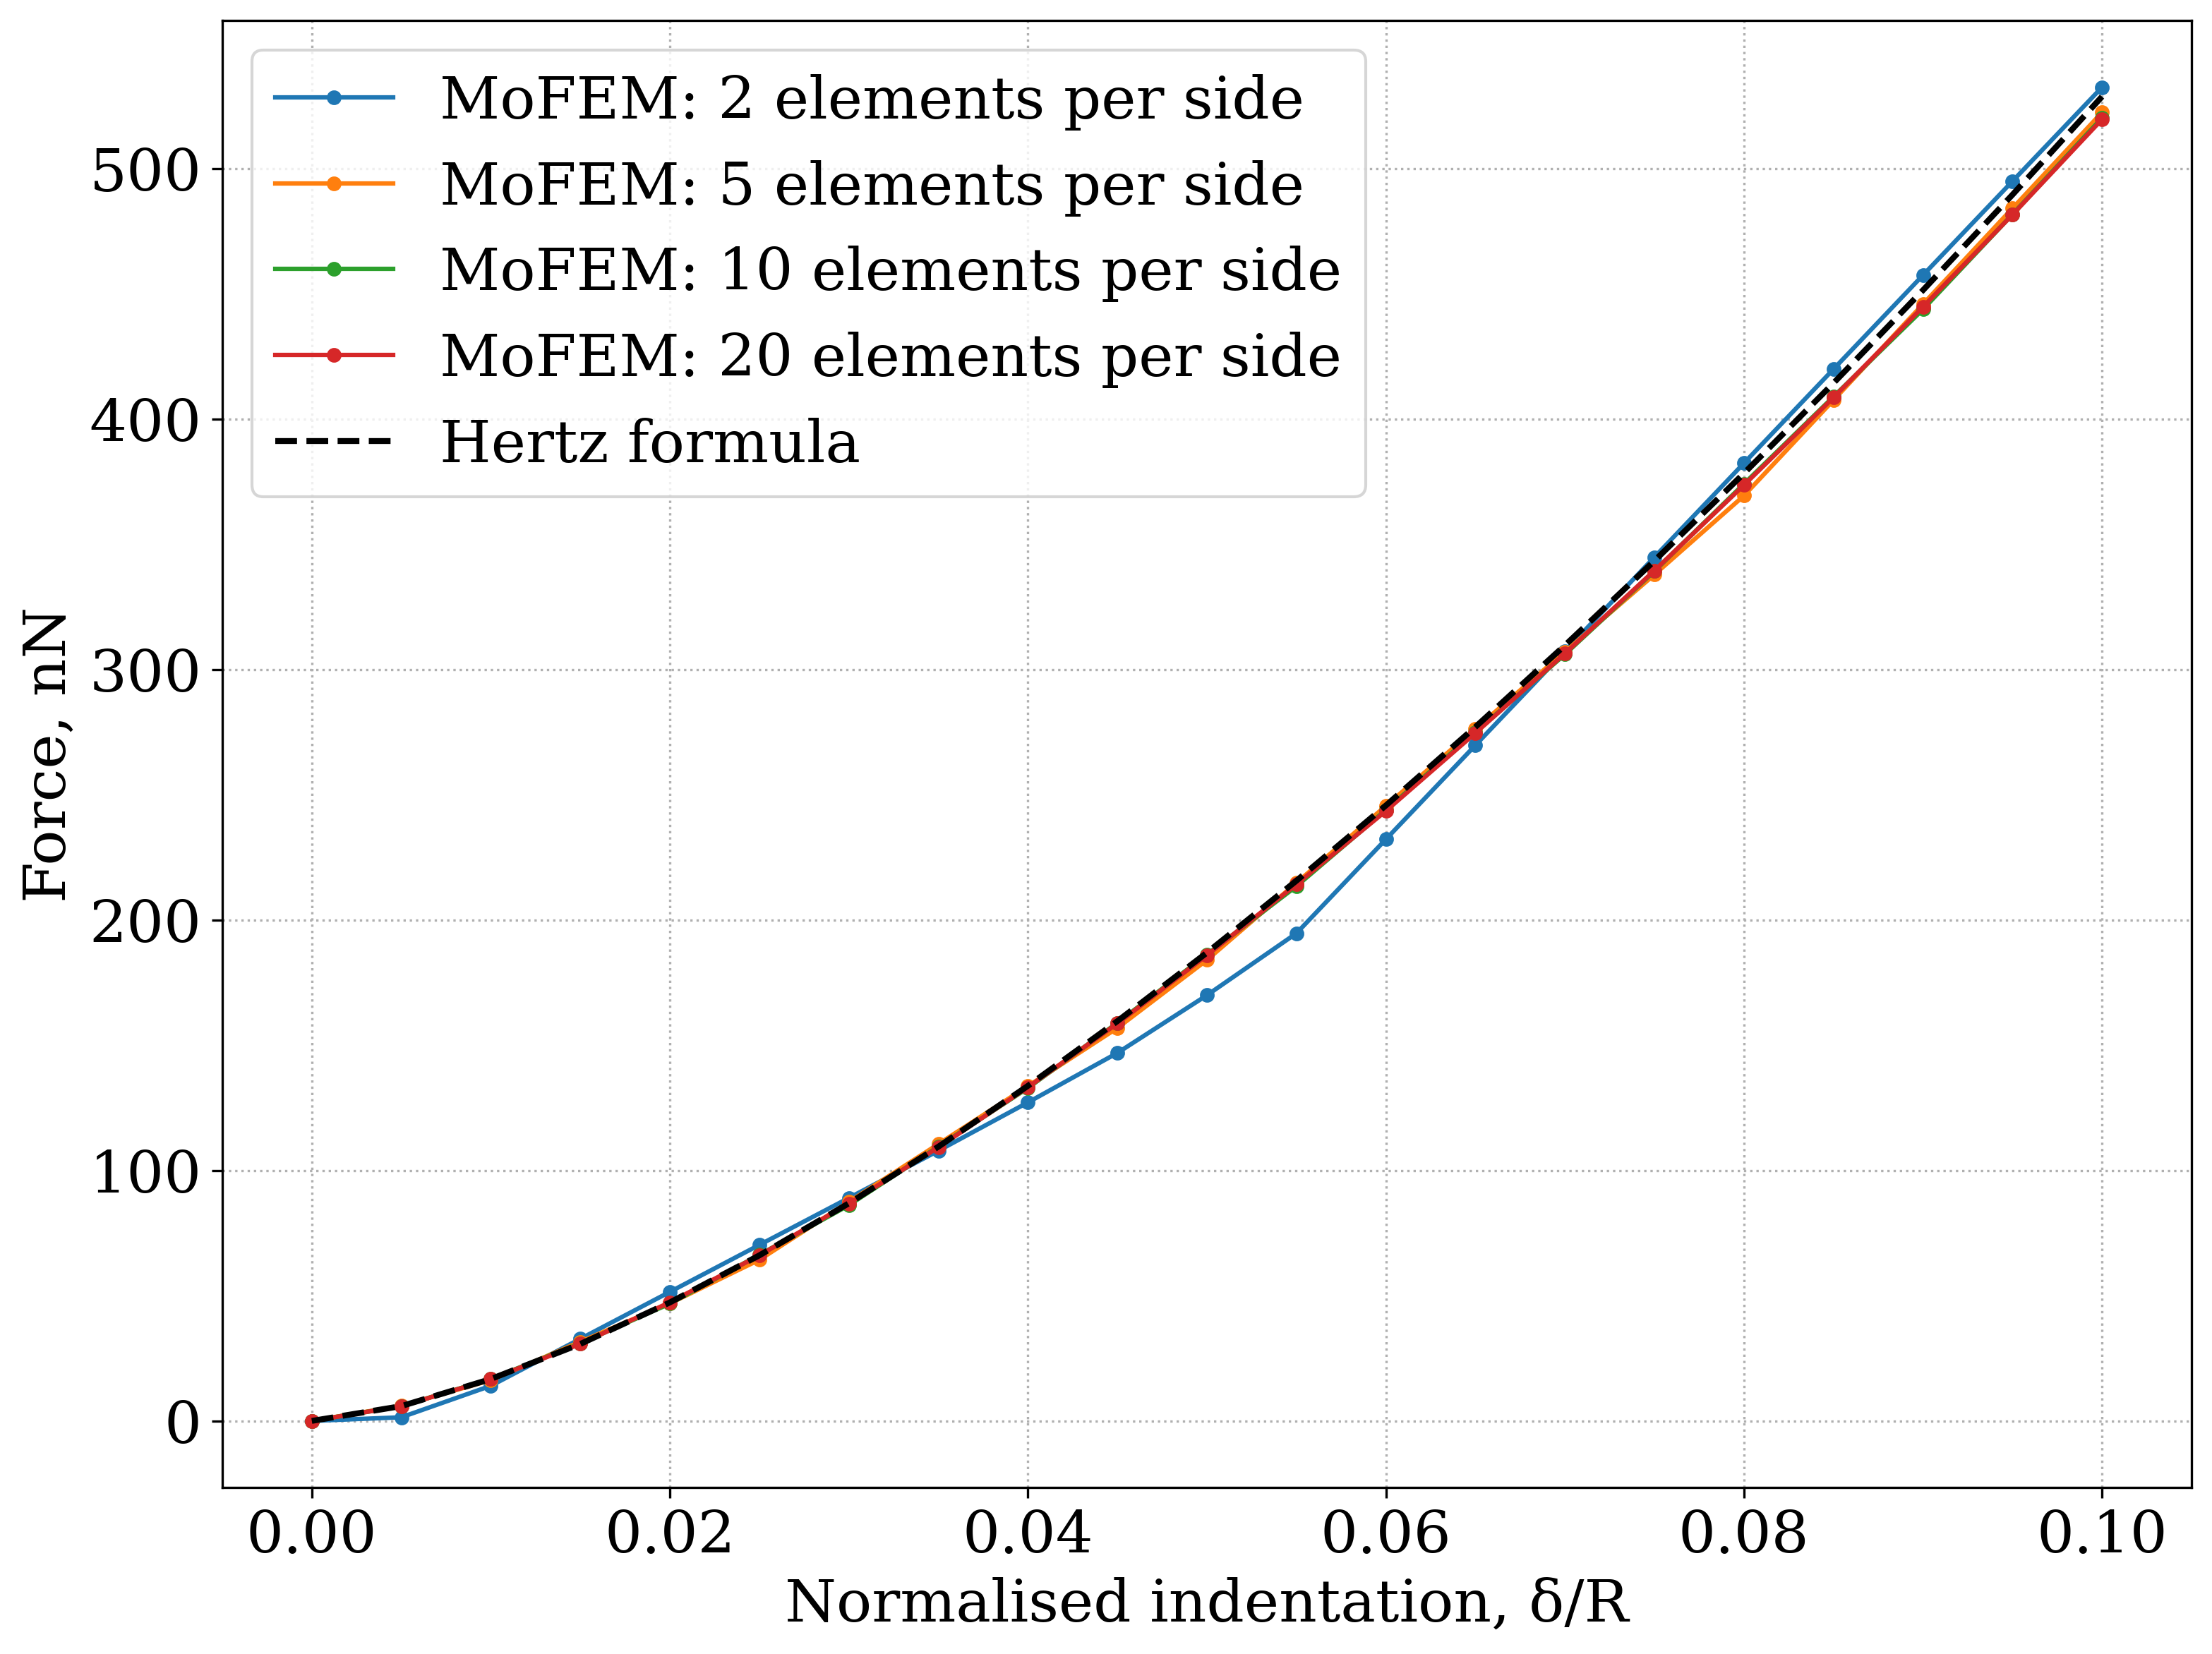

In [9]:
for elem_num, indent, force in zip(elem_num_list, indent_list, force_list):
    plt.plot(indent / params.indenter_radius, force, marker='o', ms=4, lw=1.5, label="MoFEM: {} elements per side".format(elem_num))
    
plt.plot(indent/params.indenter_radius, hertz_press(indent, params), c='k', ls='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")

### Convergence w.r.t. mesh height

In [10]:
length_mult_list = [5, 10, 20, 40]
indent_list = []
force_list = []

params.young_modulus = 100
params.poisson_ratio = 0.45
params.material_model = "LinearElasticity"

params.show_mesh = False

for length_mult in length_mult_list:
    params.mesh_length = params.refine_radius * length_mult
    params.mesh_height = params.mesh_length * 2
    
    params.far_field_size = params.mesh_height / 10
    params.near_field_size = params.refine_radius / 10

    generate_mesh(params)
    
    indent, force, area = mofem_compute_force_indent(params)
    indent_list.append(indent)
    force_list.append(force)

3.1622776601683795 31.622776601683796 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00366144s, CPU 0.003963s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00620595s, CPU 0.006195s)
Info    : 379 nodes 778 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:13:15
[0] <inform> UTC time: 2024-7-27 15:13:15
[0] <inform> [MED] Reading MED file V

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force: time 0.000e+00 Fx: 0.000000e+00 Fy: 0.000000e+00 Fz:

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3459e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.4769e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.4701e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.8039e+02
[0] <inform> [Essential] Total force: 1.3459e-01 6.4701e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -6.8133e+02
[0] <inform> [Indent] Ux time 2.5000e-01 min -4.8968e-03 max 2.6200e-02
[0] <inform> [Indent] Uy time 2.5000e-01 min -2.4997e-01 max 1.0456e-02
[0] <inform> [Indent] Contact force: time 2.500e-01 Fx: -6.038728e+00 Fy: 6.470147e+

[0] <inform> [petsc]     3 SNES Function norm 3.393082609204e-12 [  3.392984242565e-12  ,   2.583645845556e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   9 accepted t=0.45       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 10 TS dt 0.05 time 0.5
[0] <inform> [Indent] Write file at time 0.5 write step 10
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2781e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3678e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7983e+02 0.0000e+00
[0] <inform> [Essential] M

[0] <inform> [petsc]     2 SNES Function norm 2.597305587907e-06 [  5.505694610903e-12  ,   2.597305587901e-06  ]
[0] <inform> [petsc]     3 SNES Function norm 5.963487219041e-12 [  5.963427692273e-12  ,   2.664527512973e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  14 accepted t=0.7        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 15 TS dt 0.05 time 0.75
[0] <inform> [Indent] Write file at time 0.75 write step 15
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3681e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0018e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+

[0] <inform> [petsc]     1 SNES Function norm 1.962278314854e-04 [  8.401309509611e-12  ,   1.962278314854e-04  ]
[0] <inform> [petsc]     2 SNES Function norm 1.688415000457e-11 [  8.619450759306e-12  ,   1.451825023840e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  19 accepted t=0.95       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 20 TS dt 0.05 time 1.
[0] <inform> [Indent] Write file at time 1 write step 20
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.5159e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7593e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.

[0] <inform> [BcMng] Add X SimpleProblem_U_FIX_X                          
[0] <inform> [BcMng] 
D i s p l a c e m e n t 
 
Flag for X-Translation (0/1): 1
Flag for Y-Translation (0/1): 0
Flag for Z-Translation (0/1): 0
Flag for X-Rotation (0/1): 0
Flag for Y-Rotation (0/1): 0
Flag for Z-Rotation (0/1): 0
 
Displacement magnitude (X-Translation): 0
Displacement magnitude (Y-Translation): N/A
Displacement magnitude (Z-Translation): N/A
Displacement magnitude (X-Rotation): N/A
Displacement magnitude (Y-Rotation): N/A
Displacement magnitude (Z-Rotation): N/A
 
[0] <inform> [BcMng] Add Y SimpleProblem_U_FIX_Y                          
[0] <inform> [BcMng] 
D i s p l a c e m e n t 
 
Flag for X-Translation (0/1): 0
Flag for Y-Translation (0/1): 1
Flag for Z-Translation (0/1): 0
Flag for X-Rotation (0/1): 0
Flag for Y-Rotation (0/1): 0
Flag for Z-Rotation (0/1): 0
 
Displacement magnitude (X-Translation): N/A
Displacement magnitude (Y-Translation): 0
Displacement magnitude (Z-Translation): N

[0] <inform> [petsc]     1 SNES Function norm 4.862194062966e-03 [  9.373104456149e-13  ,   4.862194062966e-03  ]
[0] <inform> [petsc]     2 SNES Function norm 2.813778834233e-07 [  8.930404819395e-13  ,   2.813778834219e-07  ]
[0] <inform> [petsc]     3 SNES Function norm 8.886003896365e-13 [  8.885375082645e-13  ,   1.057113376633e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   3 accepted t=0.15       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 4 TS dt 0.05 time 0.2
[0] <inform> [Indent] Write file at time 0.2 write step 4
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5685e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8339e+00
[0] <inform> [Essential] EssentialPreProc<Displ

[0] <inform> [petsc]     2 SNES Function norm 5.761992804425e-12 [  3.124279724155e-12  ,   4.841429260403e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step   8 accepted t=0.4        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 9 TS dt 0.05 time 0.45
[0] <inform> [Indent] Write file at time 0.45 write step 9
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.2813e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.8231e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.5653e+02 0.0000e+00
[0] <inform> [Essential] M

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.3745e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0785e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.0075e+02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.3253e+03
[0] <inform> [Essential] Total force: 5.3745e-01 3.0075e+02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -6.3360e+03
[0] <inform> [Indent] Ux time 7.0000e-01 min -8.9642e-03 max 7.4407e-02
[0] <inform> [Indent] Uy time 7.0000e-01 min -6.9985e-01 max 2.1528e-02
[0] <inform> [Indent] Contact force: time 7.000e-01 Fx: -4.710283e+01 Fy: 3.007466e+

[0] <inform> [petsc]     2 SNES Function norm 1.047485948241e-11 [  8.910302866390e-12  ,   5.507193841288e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.9        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 19 TS dt 0.05 time 0.95
[0] <inform> [Indent] Write file at time 0.95 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.6489e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.6390e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.7129e+02 0.0000e+00
[0] <inform> [Essential]

[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316749 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 10 name MFRONT_MAT_10
[0] <inform> [Indent] Order 2
[0] <inform> [Indent] Contact order 2
[0] <inform> [Indent] Sigma order 1
[0] <inform> [Indent] Geom order 1
[0] <inform> [Indent] Se

[0] <inform> [petsc]     1 SNES Function norm 1.376373661899e-01 [  3.211867885582e-14  ,   1.376373661899e-01  ]
[0] <inform> [petsc]     2 SNES Function norm 1.427617937204e-02 [  4.493357533165e-13  ,   1.427617937204e-02  ]
[0] <inform> [petsc]     3 SNES Function norm 5.376446618648e-04 [  1.149931439881e-13  ,   5.376446618648e-04  ]
[0] <inform> [petsc]     4 SNES Function norm 4.614778241476e-12 [  1.227315342463e-13  ,   4.613145910168e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 1 TS dt 0.05 time 0.05
[0] <inform> [Indent] Write file at time 0.05 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1537e-01 0.0000e+00 0.0000e+0

[0] <inform> [petsc]     3 SNES Function norm 1.658959758578e-12 [  1.658920590543e-12  ,   1.139977423414e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   5 accepted t=0.25       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 6 TS dt 0.05 time 0.3
[0] <inform> [Indent] Write file at time 0.3 write step 6
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5546e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.5634e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.5715e+01 0.0000e+00
[0] <inform> [Essential] Mom

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.0557e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5867e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.1224e+02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.9265e+03
[0] <inform> [Essential] Total force: 5.0557e-01 2.1224e+02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -8.9424e+03
[0] <inform> [Indent] Ux time 5.5000e-01 min -8.6316e-03 max 5.8409e-02
[0] <inform> [Indent] Uy time 5.5000e-01 min -5.4988e-01 max 2.0795e-02
[0] <inform> [Indent] Contact force: time 5.500e-01 Fx: -2.936819e+01 Fy: 2.122392e+

[0] <inform> [petsc]     1 SNES Function norm 7.529702275599e-05 [  7.403481121297e-12  ,   7.529702275599e-05  ]
[0] <inform> [petsc]     2 SNES Function norm 7.884431162692e-12 [  7.494228477476e-12  ,   2.449651870494e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  15 accepted t=0.75       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 16 TS dt 0.05 time 0.8
[0] <inform> [Indent] Write file at time 0.8 write step 16
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 8.0131e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.7253e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00

3.1622776601683795 252.98221281347037 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00691821s, CPU 0.007094s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00914834s, CPU 0.009867s)
Info    : 553 nodes 1126 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:13:25
[0] <inform> UTC time: 2024-7-27 15:13:25
[0] <inform> [MED] Reading MED file 

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force: time 0.000e+00 Fx: 0.000000e+00 Fy: 0.000000e+00 Fz:

[0] <inform> [petsc]     2 SNES Function norm 5.566071949232e-08 [  1.406519133998e-12  ,   5.566071947455e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.2        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 5 TS dt 0.05 time 0.25
[0] <inform> [Indent] Write file at time 0.25 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5275e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.9536e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.6254e+01 0.0000e+00
[0] <inform> [Essenti

[0] <inform> [petsc]     1 SNES Function norm 2.876583906167e-05 [  3.921142577310e-12  ,   2.876583906167e-05  ]
[0] <inform> [petsc]     2 SNES Function norm 3.873330836395e-12 [  3.845450527352e-12  ,   4.638987064561e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step   9 accepted t=0.45       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 10 TS dt 0.05 time 0.5
[0] <inform> [Indent] Write file at time 0.5 write step 10
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.5186e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.7525e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 9.994621018082e-05 [  7.134643701046e-12  ,   9.994621018081e-05  ]
[0] <inform> [petsc]     2 SNES Function norm 8.333479433117e-12 [  7.008421230864e-12  ,   4.508759398433e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  14 accepted t=0.7        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 15 TS dt 0.05 time 0.75
[0] <inform> [Indent] Write file at time 0.75 write step 15
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 9.1511e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.9621e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+

[0] <inform> [petsc]     1 SNES Function norm 1.027698788395e-05 [  1.120057761706e-11  ,   1.027698788395e-05  ]
[0] <inform> [petsc]     2 SNES Function norm 1.143419609149e-11 [  1.143415330619e-11  ,   3.127985202047e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  19 accepted t=0.95       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 20 TS dt 0.05 time 1.
[0] <inform> [Indent] Write file at time 1 write step 20
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3211e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.5359e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.

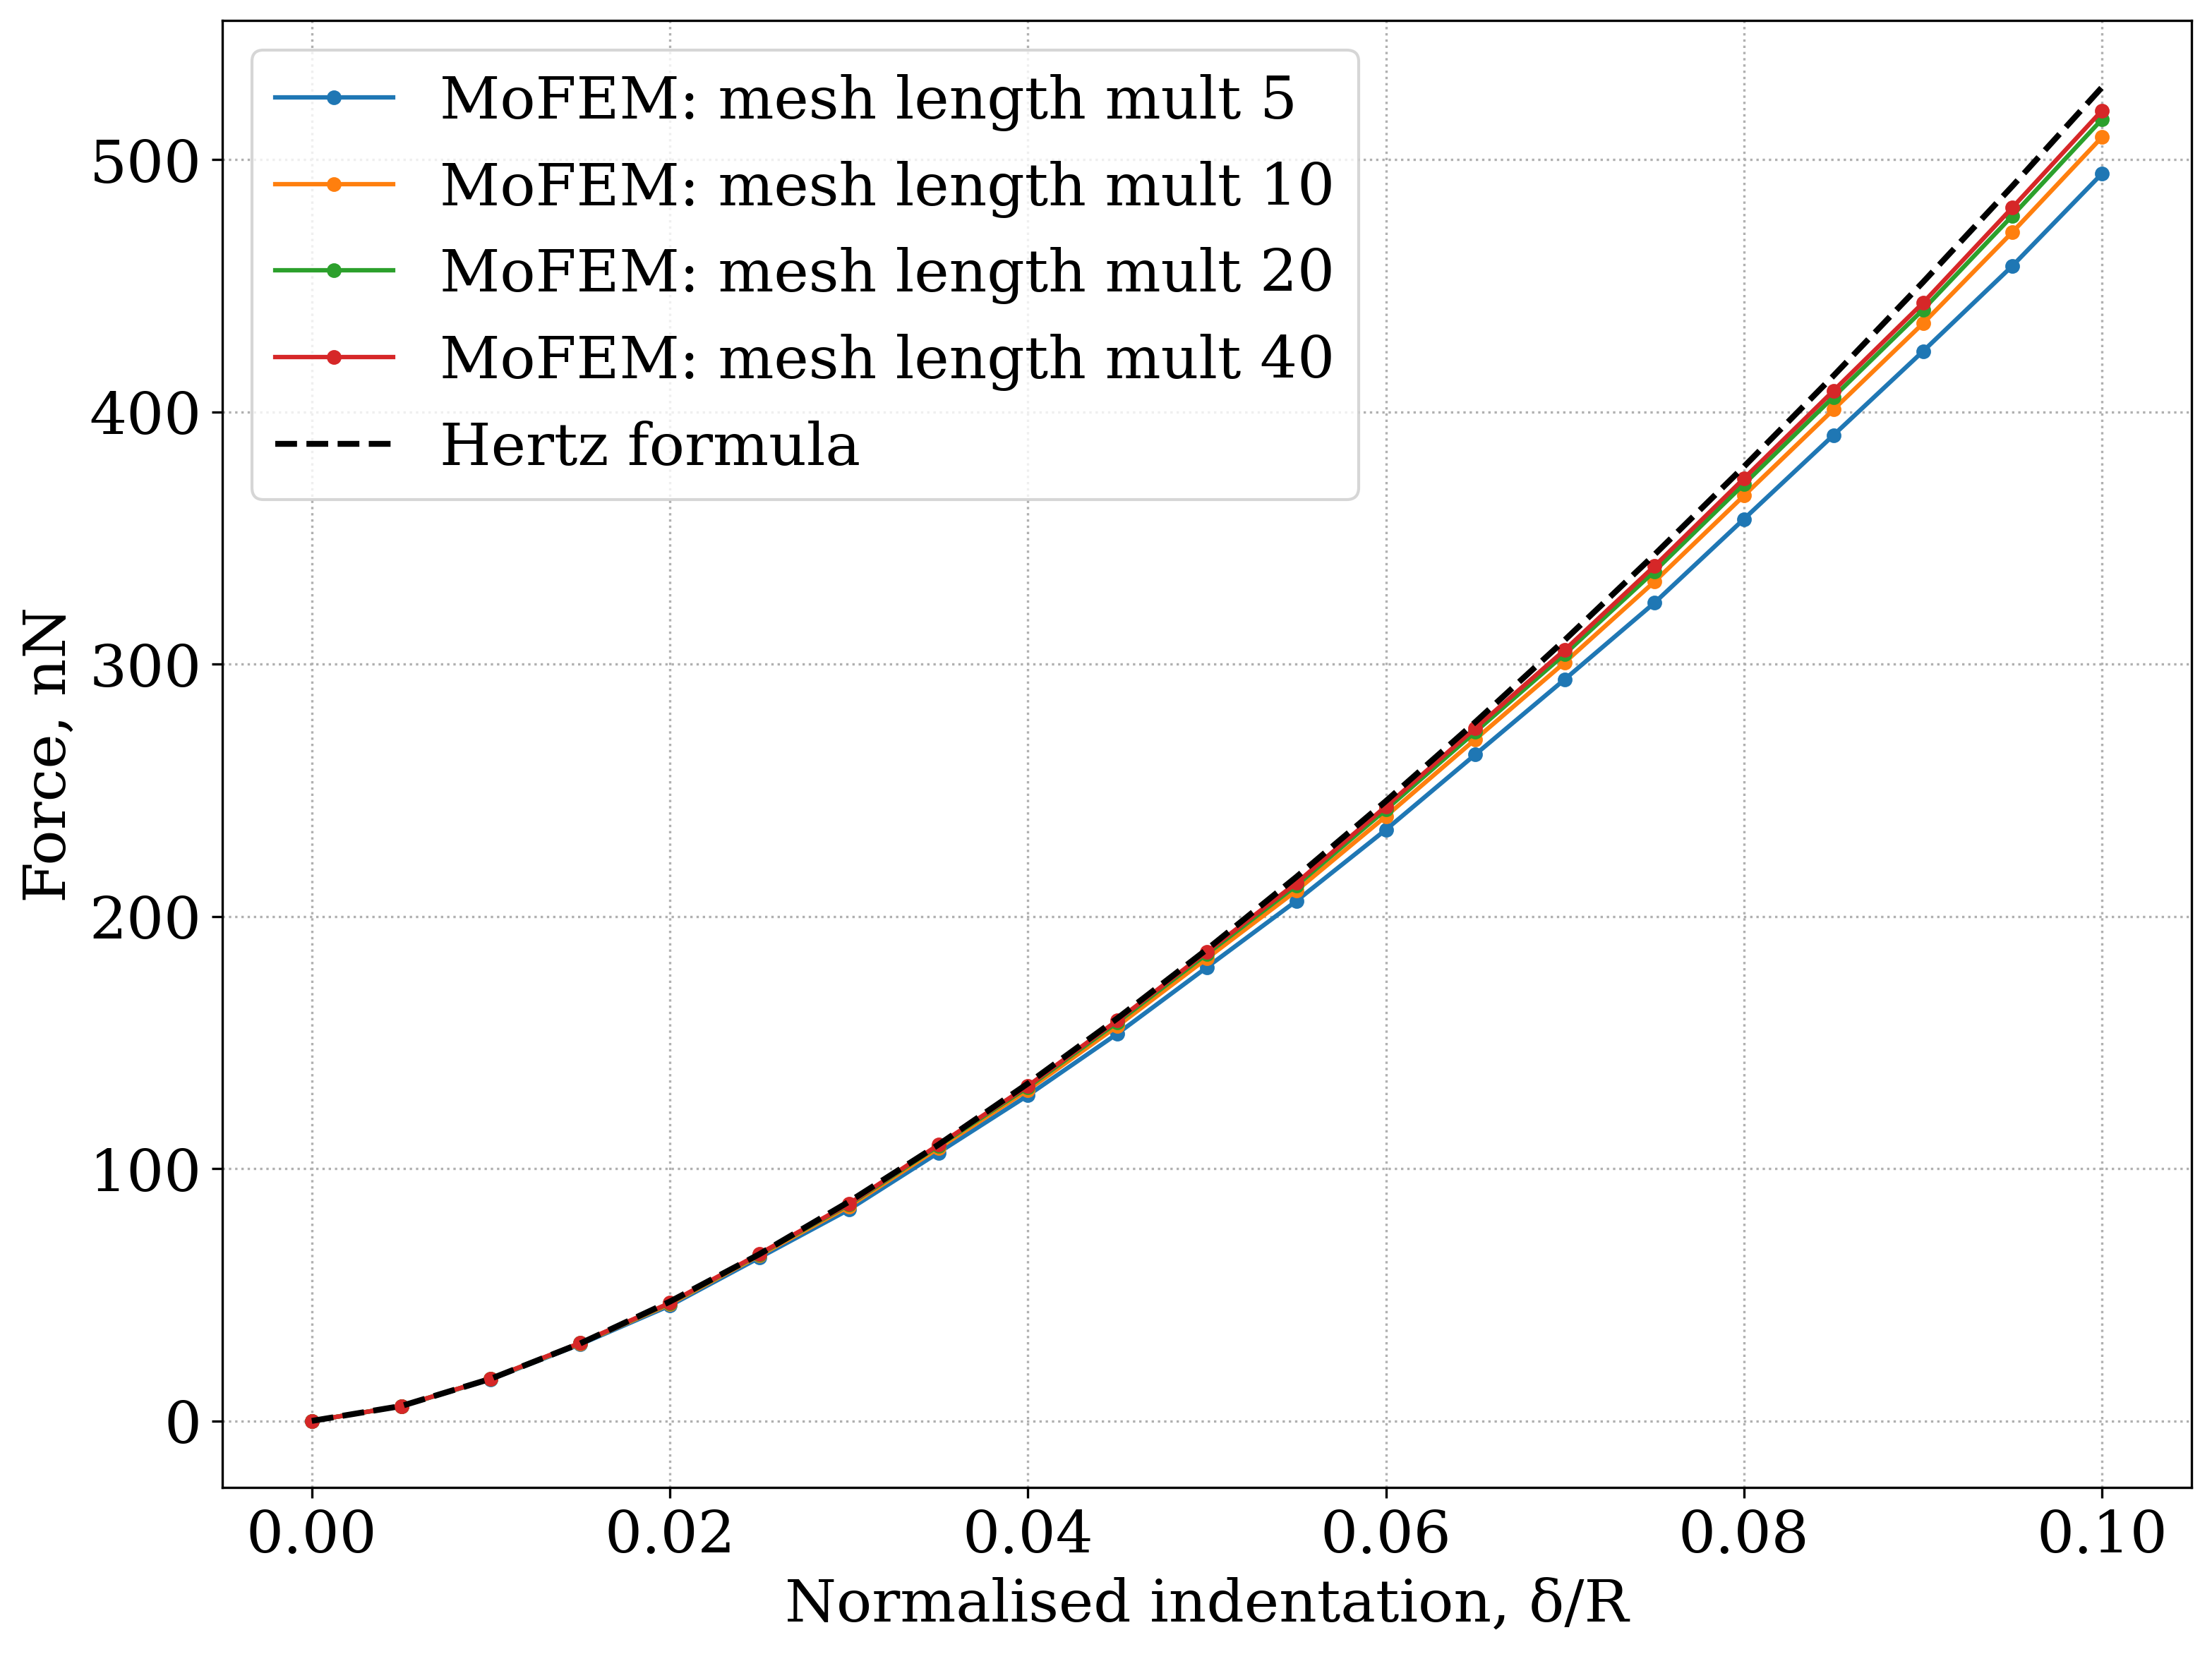

In [11]:
for length_mult, indent, force in zip(length_mult_list, indent_list, force_list):
    plt.plot(indent / params.indenter_radius, force, marker='o', ms=4, lw=1.5, label="MoFEM: mesh length mult {}".format(length_mult))
    
plt.plot(indent/params.indenter_radius, hertz_press(indent, params), c='k', ls ='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")

### Elastic test

In [12]:
params.far_field_size = params.mesh_height / 10
params.near_field_size = params.refine_radius / 10

params.mesh_length = params.refine_radius * 40
params.mesh_height = params.mesh_length * 2

params.indenter_radius = 10 
params.max_indentation = 10 

params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 40
params.mesh_height = params.mesh_length * 2

params.far_field_size = params.mesh_height / 10
params.near_field_size = params.refine_radius / 10

params.show_mesh = True
generate_mesh(params)

10.0 800.0 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00714592s, CPU 0.007036s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00908412s, CPU 0.008971s)
Info    : 553 nodes 1126 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:13:29
[0] <inform> UTC time: 2024-7-27 15:13:29
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4

Scene(background_color='#ffffff', camera={'position': [194.57559204101562, -390.0, 885.1827179843779], 'target…

In [13]:
params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "LinearElasticity"

indent_1, force_1, area_1 = mofem_compute_force_indent(params)

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 940795ae65ee14ad214aeb702914b97273f9ea80
[0] <inform> Local time: 2024-7-27 15:13:31
[0] <inform> UTC time: 2024-7-27 15:13:31
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316749 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y                          
[0] <inform> [MeshsetMng] meshset in database 

[0] <inform> [petsc]     1 SNES Function norm 3.375703358359e+00 [  1.511748052623e-11  ,   3.375703358359e+00  ]
[0] <inform> [petsc]     2 SNES Function norm 1.123617391367e-02 [  3.346314753145e-11  ,   1.123617391367e-02  ]
[0] <inform> [petsc]     3 SNES Function norm 1.185709943077e-07 [  1.951505774971e-11  ,   1.185709927017e-07  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 1 TS dt 0.05 time 0.05
[0] <inform> [Indent] Write file at time 0.05 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3801e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.1517e+02
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [petsc]     1 SNES Function norm 1.270783463182e-01 [  2.474092615299e-10  ,   1.270783463182e-01  ]
[0] <inform> [petsc]     2 SNES Function norm 9.046943200426e-07 [  2.327677377079e-10  ,   9.046942900983e-07  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step   5 accepted t=0.25       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 6 TS dt 0.05 time 0.3
[0] <inform> [Indent] Write file at time 0.3 write step 6
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.6558e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.8828e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e

[0] <inform> [petsc]     1 SNES Function norm 4.065104726805e-02 [  5.808030367453e-10  ,   4.065104726805e-02  ]
[0] <inform> [petsc]     2 SNES Function norm 1.213604803959e-06 [  5.596971357660e-10  ,   1.213604674897e-06  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  10 accepted t=0.5        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 11 TS dt 0.05 time 0.55
[0] <inform> [Indent] Write file at time 0.55 write step 11
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.9141e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.4969e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0

[0] <inform> [petsc]     2 SNES Function norm 3.116361576748e-07 [  8.541679000084e-10  ,   3.116349870722e-07  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  15 accepted t=0.75       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 16 TS dt 0.05 time 0.8
[0] <inform> [Indent] Write file at time 0.8 write step 16
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0191e+02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2767e+04
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.9865e+03 0.0000e+00
[0] <inform> [Essenti

In [14]:
params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "NeoHookeanHyperElasticity"

indent_2, force_2, area_2 = mofem_compute_force_indent(params)

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 940795ae65ee14ad214aeb702914b97273f9ea80
[0] <inform> Local time: 2024-7-27 15:13:33
[0] <inform> UTC time: 2024-7-27 15:13:33
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316749 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y                          
[0] <inform> [MeshsetMng] meshset in database 

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.5957e-27 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7714e-24
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 -9.3634e-10 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 2.4969e-07
[0] <inform> [Essential] Total force: 7.5957e-27 -9.3634e-10 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 2.4969e-07
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force: time 0.000e+00 Fx: 0.000000e+00 Fy: 0.000000e+00 

[0] <inform> [petsc]     3 SNES Function norm 4.785918603931e-03 [  4.785918569457e-03  ,   5.744339112915e-07  ]
[0] <inform> [petsc]     4 SNES Function norm 1.509098103093e-07 [  1.509098101651e-07  ,   6.598459675313e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   3 accepted t=0.15       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 4 TS dt 0.05 time 0.2
[0] <inform> [Indent] Write file at time 0.2 write step 4
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.7137e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2746e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e

[0] <inform> [petsc]     1 SNES Function norm 1.574174022671e+01 [  1.574173984447e+01  ,   3.469064802383e-03  ]
[0] <inform> [petsc]     2 SNES Function norm 6.083989200054e-01 [  6.083989096351e-01  ,   1.123320859678e-04  ]
[0] <inform> [petsc]     3 SNES Function norm 2.674041263127e-05 [  2.674041260584e-05  ,   1.166278092971e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   8 accepted t=0.4        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 9 TS dt 0.05 time 0.45
[0] <inform> [Indent] Write file at time 0.45 write step 9
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.2934e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.3410e+03
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [petsc]     6 SNES Function norm 1.246641672265e-05 [  1.246589203762e-05  ,   1.143748617461e-07  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 6
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.6        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 13 TS dt 0.05 time 0.65
[0] <inform> [Indent] Write file at time 0.65 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 9.7907e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2343e+04
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.0887e+03 0.0000e+00
[0] <inform> [Essen

[0] <inform> [petsc]     1 SNES Function norm 1.303517485336e+01 [  1.301338443500e+01  ,   7.533983040991e-01  ]
[0] <inform> [petsc]     2 SNES Function norm 9.757954172022e+00 [  9.744032319847e+00  ,   5.210602393863e-01  ]
[0] <inform> [petsc]     3 SNES Function norm 6.858762648336e+00 [  6.851958710065e+00  ,   3.054290453933e-01  ]
[0] <inform> [petsc]     4 SNES Function norm 3.710972560035e+00 [  3.710189750455e+00  ,   7.621913768381e-02  ]
[0] <inform> [petsc]     5 SNES Function norm 1.836133464522e-01 [  1.836008826126e-01  ,   2.139368891654e-03  ]
[0] <inform> [petsc]     6 SNES Function norm 1.023562934827e-04 [  1.023500736297e-04  ,   1.128380929301e-06  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 6
[0] <inform> [petsc]       TSAdapt none beuler 0: step  17 accepted t=0.85       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 18 TS dt 0.05 time 0.9
[0] <inform> [Indent] Write file at time 0.9 write step 18
[0] <inform>

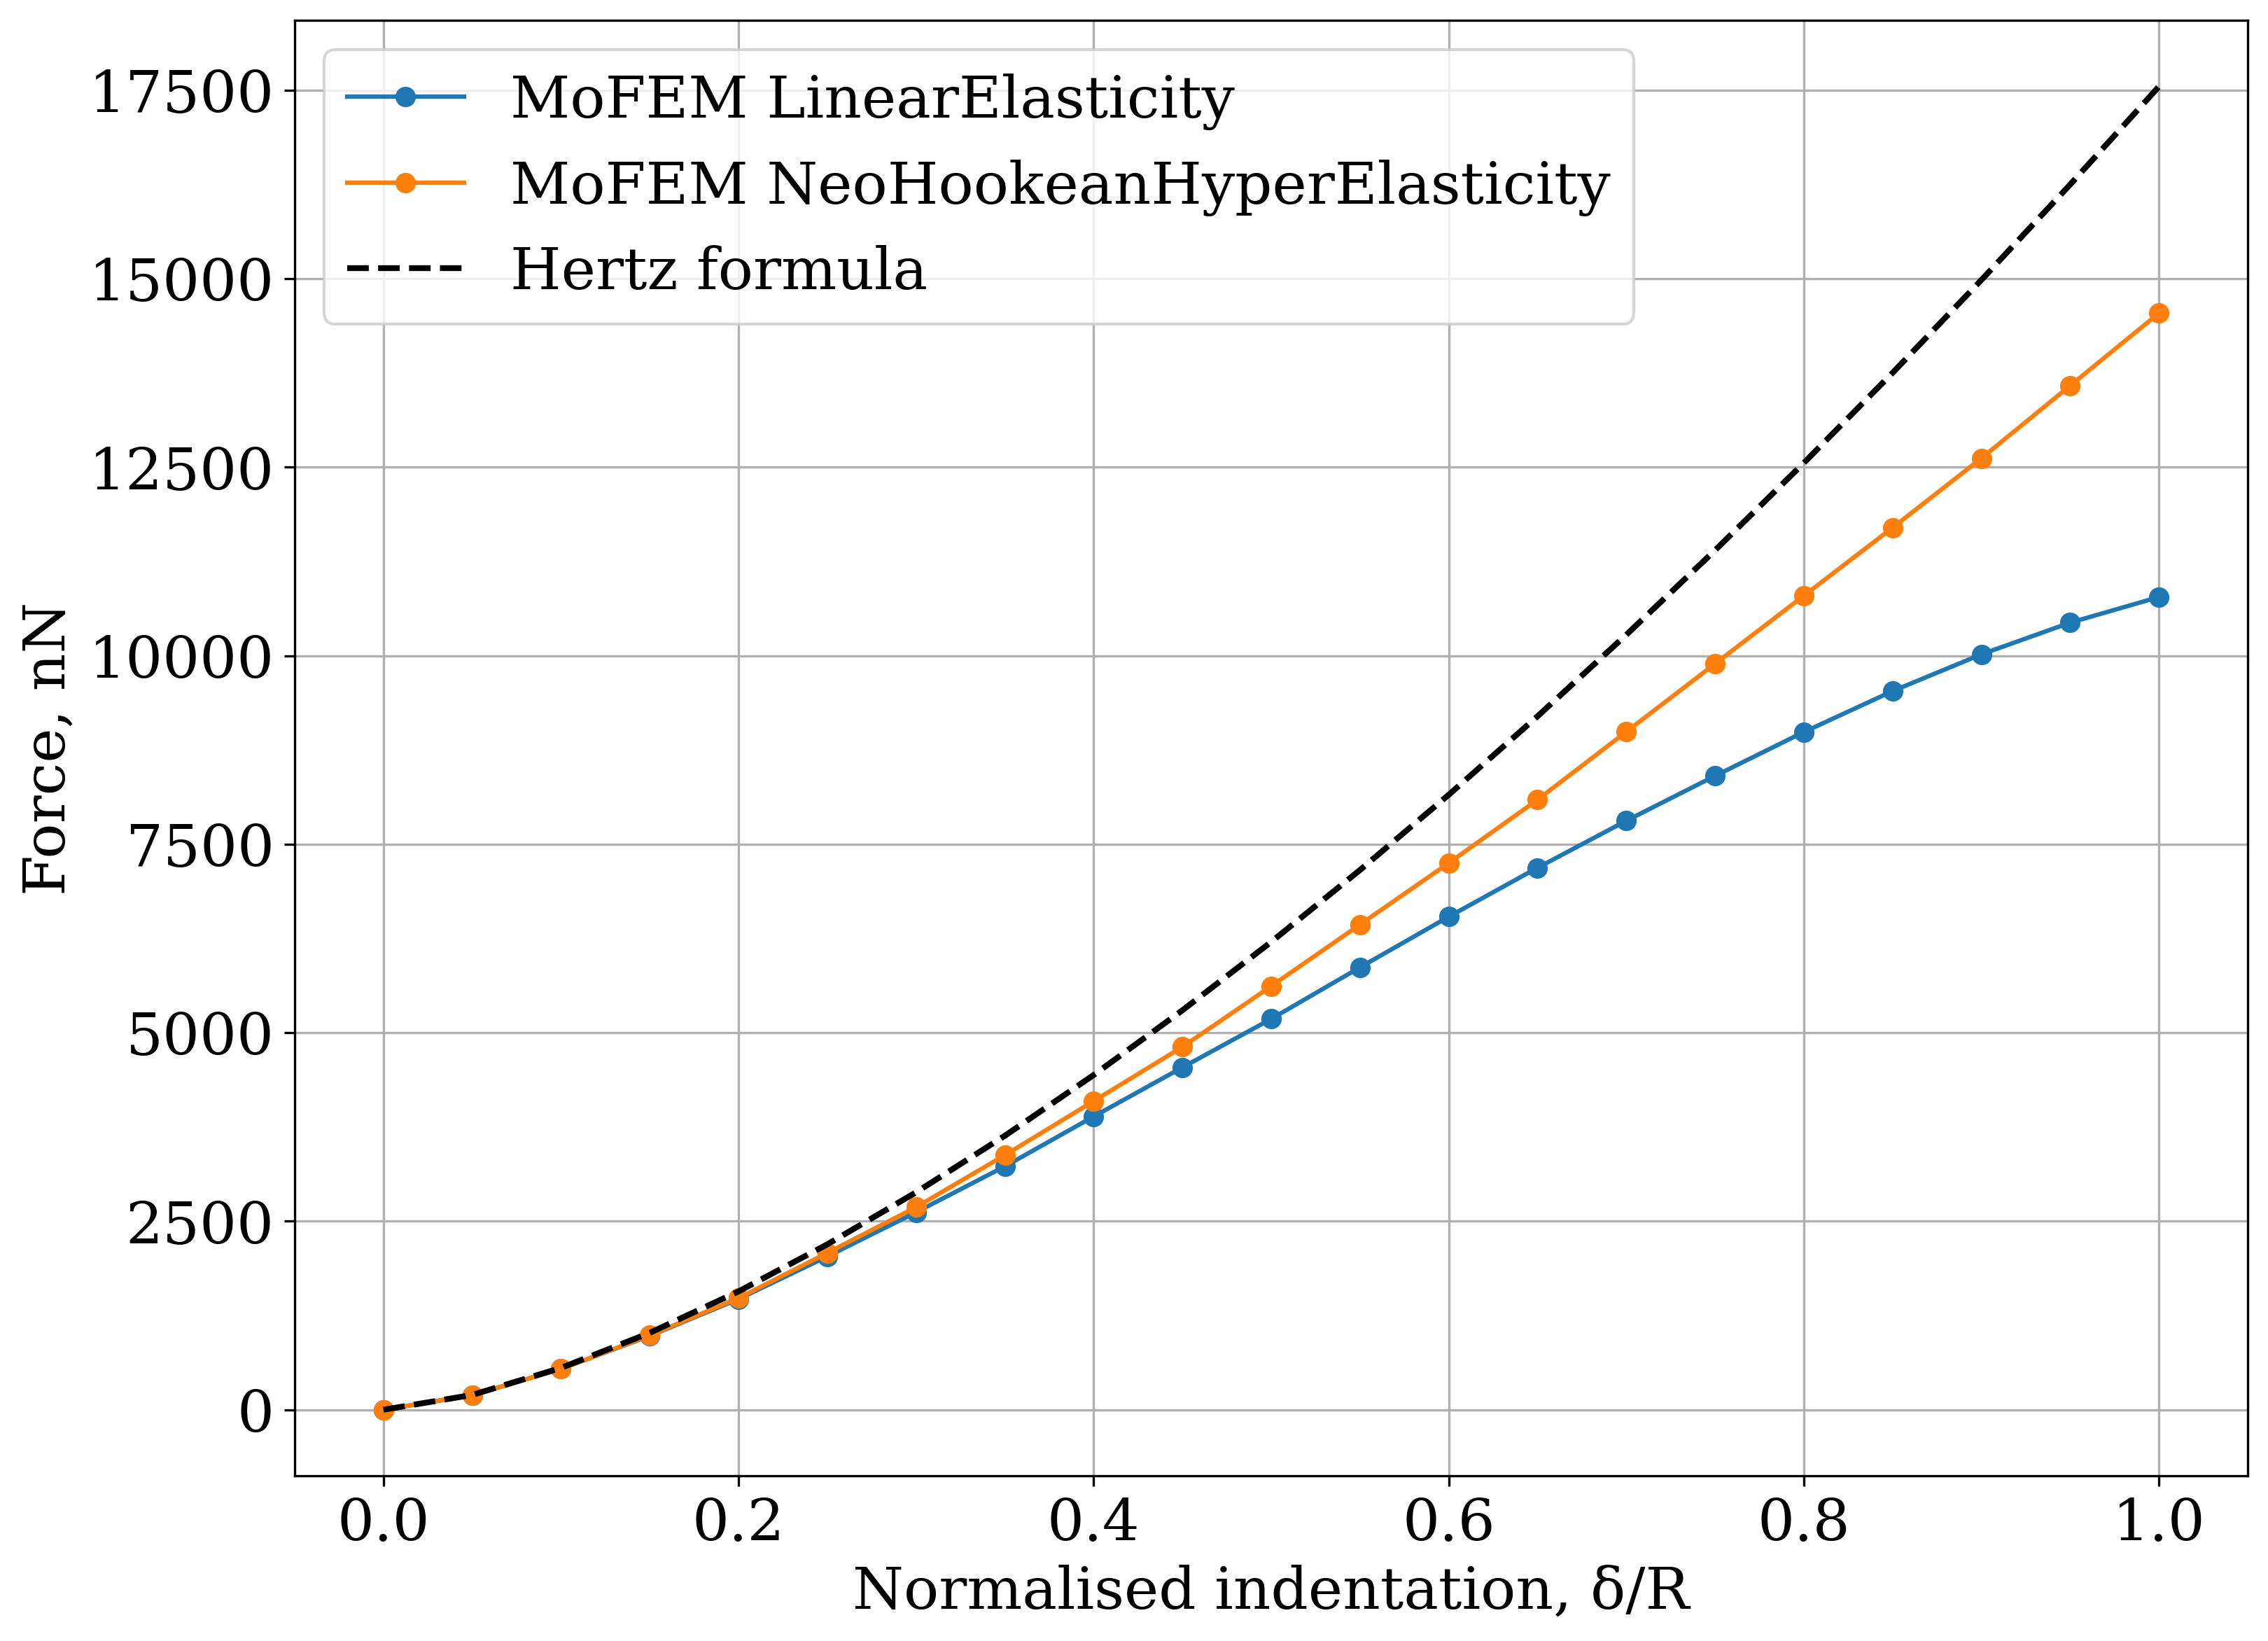

In [15]:
plt.plot(indent_1/params.indenter_radius, force_1, marker='o', ms=6, label="MoFEM LinearElasticity", lw=1.5)
plt.plot(indent_2/params.indenter_radius, force_2, marker='o', ms=6, label="MoFEM NeoHookeanHyperElasticity", lw=1.5)

plt.plot(indent_1/params.indenter_radius, hertz_press(indent_1, params), c='k', ls='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid()

### Comparison of the contact area evolution

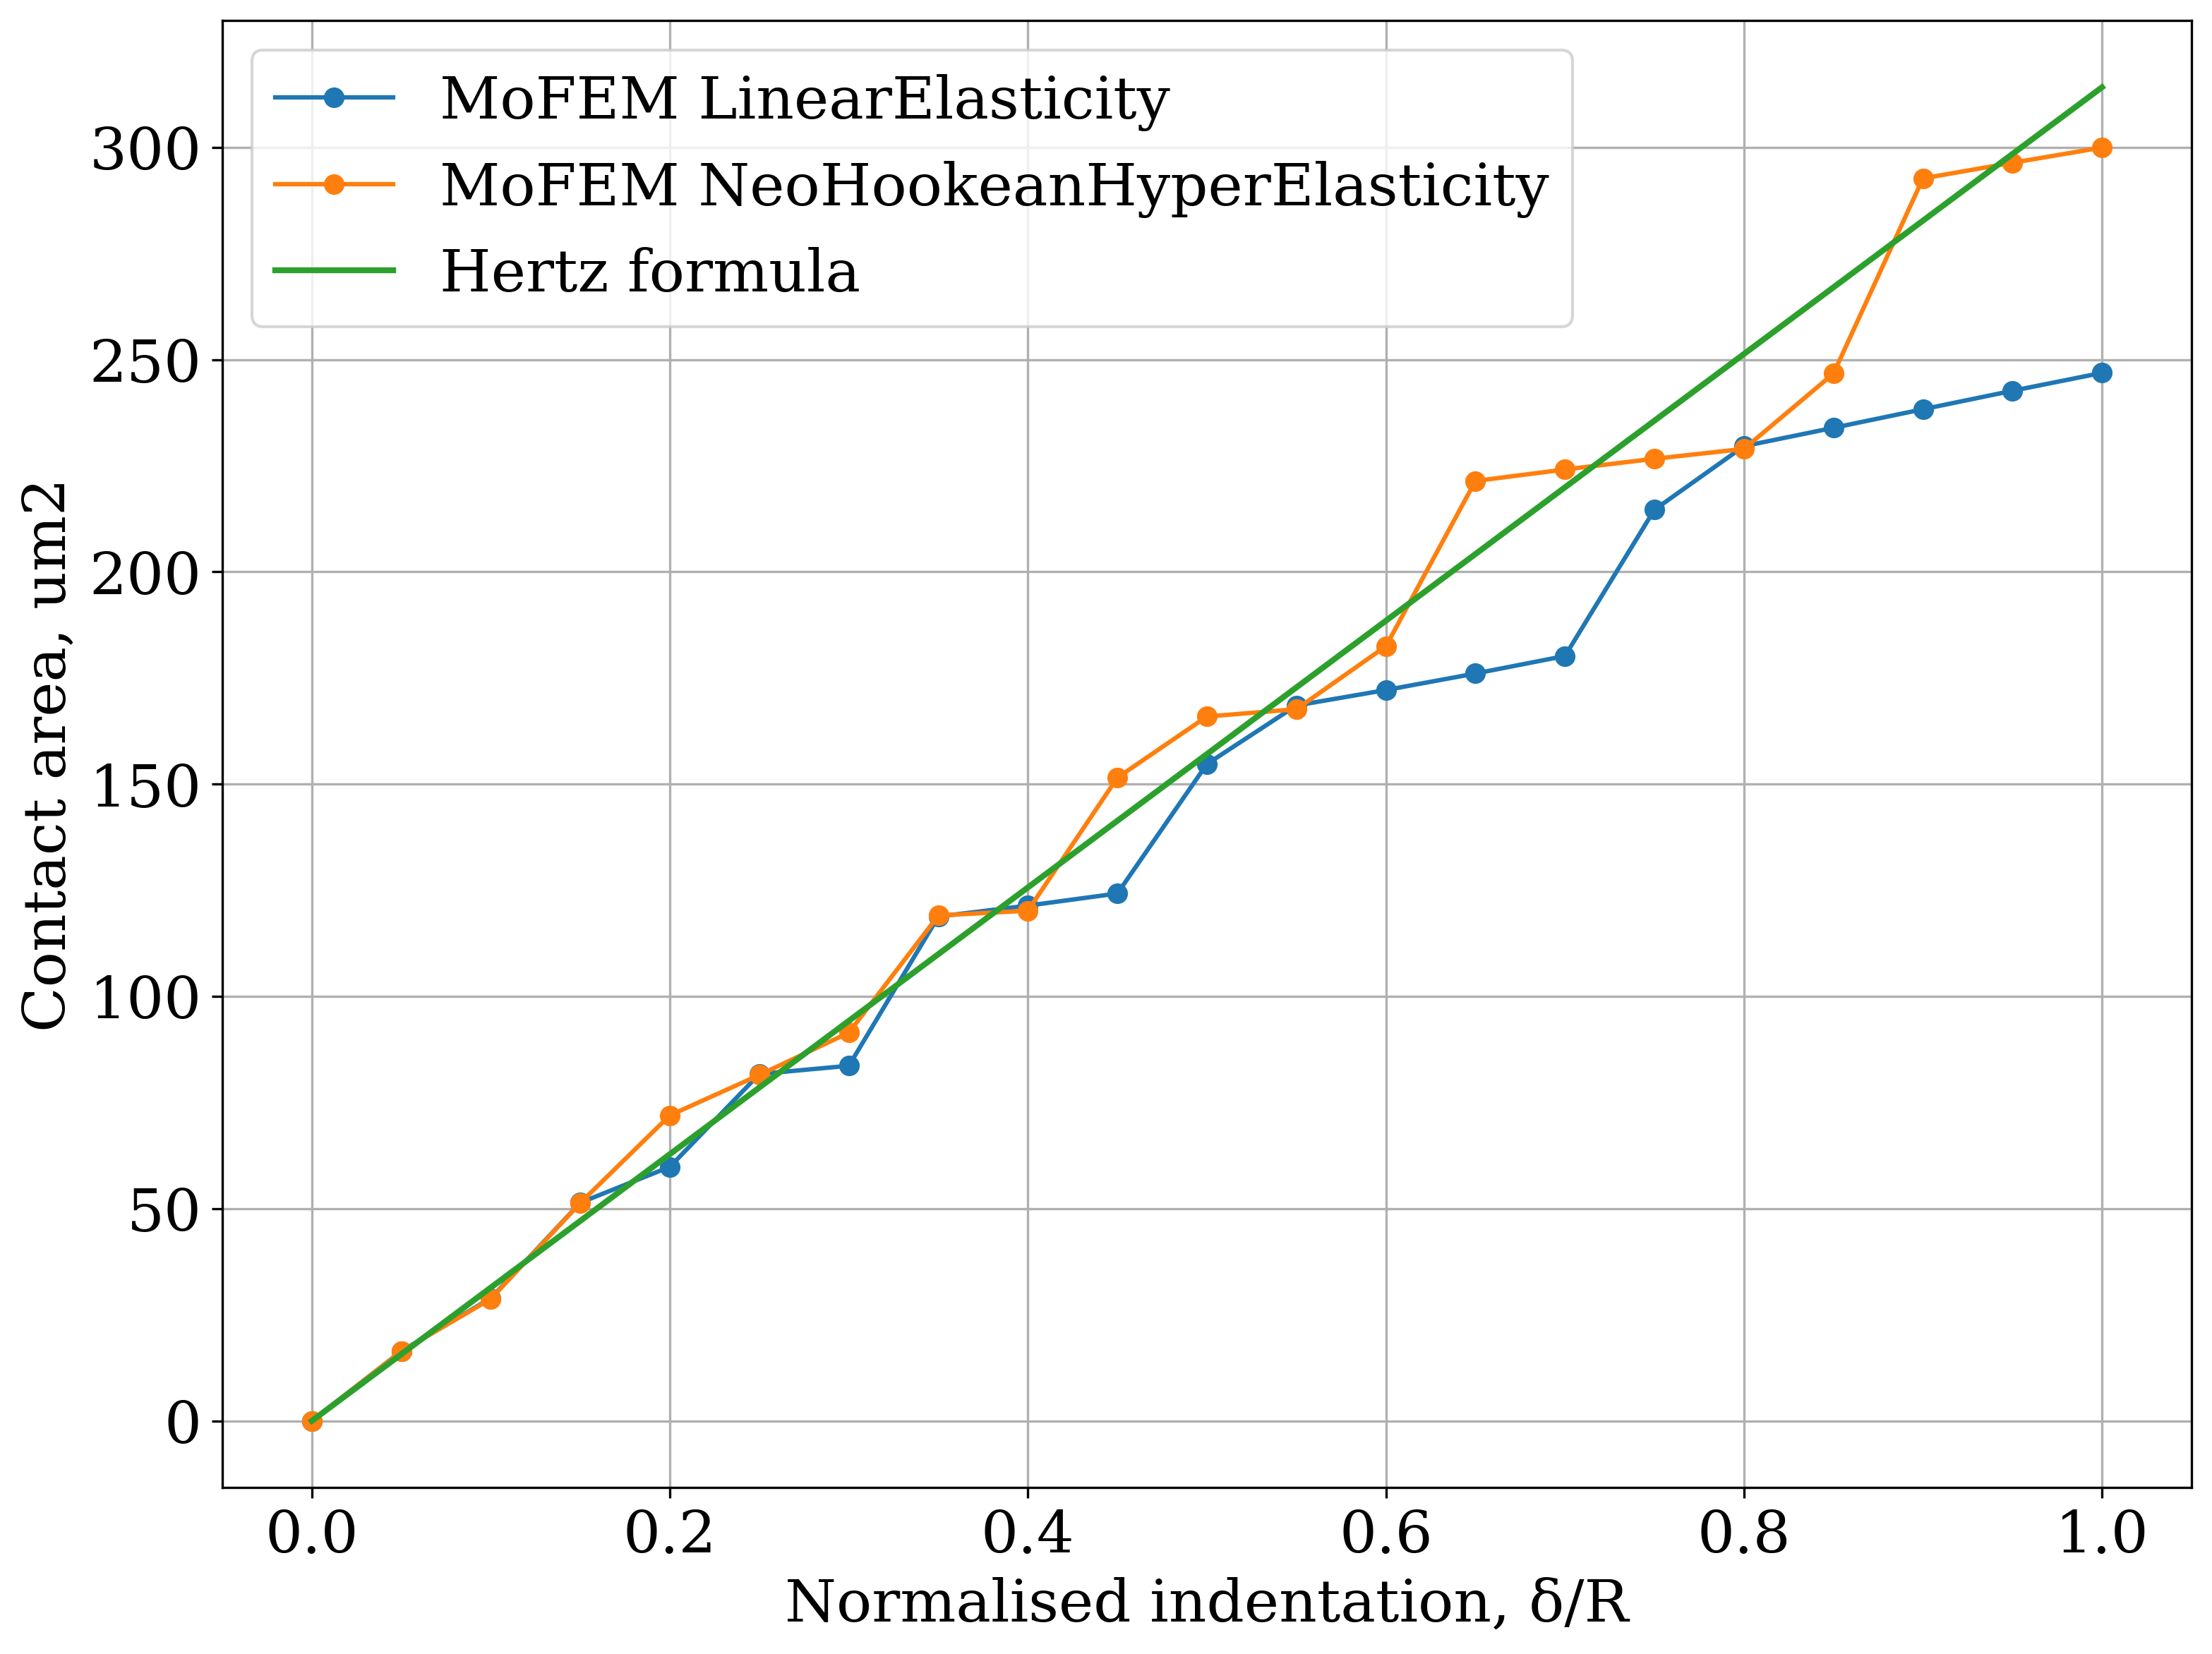

In [16]:
plt.plot(indent_1/params.indenter_radius, area_1, marker='o', ms=6, label="MoFEM LinearElasticity", lw=1.5)
plt.plot(indent_2/params.indenter_radius, area_2, marker='o', ms=6, label="MoFEM NeoHookeanHyperElasticity", lw=1.5)

plt.plot(indent_2/params.indenter_radius, hertz_area(indent_2, params), label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Contact area, um2")
plt.legend(loc='upper left')
plt.grid()

### Visualisation of the deformation

In [17]:
params.show_field = "DISPLACEMENT"
params.show_component = "Y"
params.show_edges = False

show_results(params)

out_mi_20.h5m
Read "out_mi_20.h5m"
Wrote "out_mi_20.vtk"


AppLayout(children=(VBox(children=(HTML(value='<h3>DISPLACEMENT</h3>'), Dropdown(description='Colormap:', opti…

In [18]:
params.show_field = "STRESS"
params.show_component = "Y"
params.show_edges = True

show_results(params)

out_mi_20.h5m
Read "out_mi_20.h5m"
Wrote "out_mi_20.vtk"


AppLayout(children=(VBox(children=(HTML(value='<h3>STRESS</h3>'), Dropdown(description='Colormap:', options=((…

## Indentation of a thin layer

In [19]:
params.max_indentation = params.indenter_radius / 2
params.mesh_height = params.indenter_radius 
params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 10
params.far_field_size = params.mesh_length / 10
params.near_field_size = params.mesh_height / 10

params.show_mesh = True
generate_mesh(params)

params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "NeoHookeanHyperElasticity"

mofem_compute_force_indent(params)

7.0710678118654755 10 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.0038899s, CPU 0.004245s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00453613s, CPU 0.004568s)
Info    : 280 nodes 574 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:13:39
[0] <inform> UTC time: 2024-7-27 15:13:39
[0] <inform> [MED] Reading MED file V4.1.0 using MED lib

Scene(background_color='#ffffff', camera={'position': [30.331626892089844, 5.0, 83.1289061286379], 'target': (…

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 940795ae65ee14ad214aeb702914b97273f9ea80
[0] <inform> Local time: 2024-7-27 15:13:41
[0] <inform> UTC time: 2024-7-27 15:13:41
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316749 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y1                         
[0] <inform> [MeshsetMng] meshset in database 

[0] <inform> [petsc]     1 SNES Function norm 4.156803057473e+00 [  4.017830497532e+00  ,   1.065856346664e+00  ]
[0] <inform> [petsc]     2 SNES Function norm 5.713294320935e+00 [  5.649556186859e+00  ,   8.510269614714e-01  ]
[0] <inform> [petsc]     3 SNES Function norm 6.072583630082e+00 [  6.034241114328e+00  ,   6.813267340190e-01  ]
[0] <inform> [petsc]     4 SNES Function norm 5.878633153274e+00 [  5.853304933997e+00  ,   5.451138417062e-01  ]
[0] <inform> [petsc]     5 SNES Function norm 5.398773132498e+00 [  5.381619627339e+00  ,   4.300250258038e-01  ]
[0] <inform> [petsc]     6 SNES Function norm 4.739076603874e+00 [  4.727961208566e+00  ,   3.243915345457e-01  ]
[0] <inform> [petsc]     7 SNES Function norm 3.880881628331e+00 [  3.875055052547e+00  ,   2.125806972486e-01  ]
[0] <inform> [petsc]     8 SNES Function norm 2.598915891701e+00 [  2.597949392877e+00  ,   7.087146240071e-02  ]
[0] <inform> [petsc]     9 SNES Function norm 2.713392094364e-01 [  2.713185826486e-01  

[0] <inform> [petsc]     1 SNES Function norm 5.502979940231e+01 [  5.502726284680e+01  ,   5.283614748568e-01  ]
[0] <inform> [petsc]     2 SNES Function norm 2.462389342545e+01 [  2.462326290464e+01  ,   1.762139528600e-01  ]
[0] <inform> [petsc]     3 SNES Function norm 3.952156041861e+00 [  3.952154431817e+00  ,   3.567392439319e-03  ]
[0] <inform> [petsc]     4 SNES Function norm 1.253997205124e-03 [  1.253997193734e-03  ,   1.690132925335e-07  ]
[0] <inform> [petsc]     5 SNES Function norm 5.684085232364e-09 [  5.684085229716e-09  ,   1.734971237858e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 5
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.2        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 5 TS dt 0.05 time 0.25
[0] <inform> [Indent] Write file at time 0.25 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [E

[0] <inform> [petsc]     3 SNES Function norm 3.305783630687e-07 [  3.305783623795e-07  ,   2.134717492012e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   8 accepted t=0.4        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 9 TS dt 0.05 time 0.45
[0] <inform> [Indent] Write file at time 0.45 write step 9
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8011e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.5976e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y1                         
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.6874e+03 0.0000e+00
[0] <inform> [Essenti

[0] <inform> [petsc]     1 SNES Function norm 3.085565227377e+00 [  3.085565106496e+00  ,   8.636961372336e-04  ]
[0] <inform> [petsc]     2 SNES Function norm 1.354540126013e-02 [  1.354540062837e-02  ,   4.137013119451e-06  ]
[0] <inform> [petsc]     3 SNES Function norm 1.519984697309e-08 [  1.519984636680e-08  ,   4.293109723287e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.65       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 14 TS dt 0.05 time 0.7
[0] <inform> [Indent] Write file at time 0.7 write step 14
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.3064e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.3504e+01
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [petsc]     3 SNES Function norm 9.914308186652e-10 [  9.914308036553e-10  ,   1.725181913210e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.9        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 19 TS dt 0.05 time 0.95
[0] <inform> [Indent] Write file at time 0.95 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3106e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1004e+02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y1                         
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 9.4448e+03 0.0000e+00
[0] <inform> [Essential]

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 array([    0.     ,    77.66935,   224.063  ,   448.1995 ,   688.764  ,
         1019.237  ,  1366.844  ,  1744.236  ,  2210.656  ,  2687.366  ,
         3175.825  ,  3742.12   ,  4356.154  ,  4986.945  ,  5635.233  ,
         6304.756  ,  7034.72   ,  7815.343  ,  8618.322  ,  9444.834  ,
        10296.25   ]),
 [0.0,
  12.58746,
  23.44961,
  28.77216,
  44.40831,
  51.79827,
  52.31218,
  82.22807,
  83.1258,
  83.95767,
  110.2628,
  122.3505,
  123.9772,
  125.5428,
  127.0447,
  159.2287,
  174.1345,
  176.5577,
  178.9476,
  181.2968,
  183.5998])

In [20]:
params.show_field = "DISPLACEMENT"
params.show_component = "X"
params.show_edges = True

show_results(params)

out_mi_20.h5m
Read "out_mi_20.h5m"
Wrote "out_mi_20.vtk"


AppLayout(children=(VBox(children=(HTML(value='<h3>DISPLACEMENT</h3>'), Dropdown(description='Colormap:', opti…

In [21]:
params.show_field = "STRESS"
params.show_component = "X"
params.show_edges = True

show_results(params)

out_mi_20.h5m
Read "out_mi_20.h5m"
Wrote "out_mi_20.vtk"


AppLayout(children=(VBox(children=(HTML(value='<h3>STRESS</h3>'), Dropdown(description='Colormap:', options=((…

In [22]:
height_mult_list = [1, 2, 4, 8, 16]
indent_list = []
force_list = []

params.indenter_radius = 10 
params.max_indentation = 5

params.young_modulus = 100
params.poisson_ratio = 0.49
params.material_model = "NeoHookeanHyperElasticity"

params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 50

    
params.near_field_size = params.refine_radius / 10
params.far_field_size = params.mesh_length / 10

params.show_mesh = False

for height_mult in height_mult_list:
    params.mesh_height = params.indenter_radius * height_mult
    
    generate_mesh(params)
    
    indent, force, area = mofem_compute_force_indent(params)
    indent_list.append(indent)
    force_list.append(force)

7.0710678118654755 10 10
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00701628s, CPU 0.00709s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00856724s, CPU 0.008578s)
Info    : 534 nodes 1087 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 3127d576820303055784bbada22a3bb336866091
[0] <inform> Local time: 2024-7-27 15:13:44
[0] <inform> UTC time: 2024-7-27 15:13:44
[0] <inform> [MED] Reading MED file V4.1.0 using MED li

[0] <inform> [petsc]     1 SNES Function norm 5.276724171528e+00 [  5.104618213799e+00  ,   1.336671565395e+00  ]
[0] <inform> [petsc]     2 SNES Function norm 7.268377968478e+00 [  7.190398836044e+00  ,   1.061829963446e+00  ]
[0] <inform> [petsc]     3 SNES Function norm 7.813325641126e+00 [  7.766642403822e+00  ,   8.528325424342e-01  ]
[0] <inform> [petsc]     4 SNES Function norm 7.594083352609e+00 [  7.563361710989e+00  ,   6.823940175033e-01  ]
[0] <inform> [petsc]     5 SNES Function norm 7.000093801866e+00 [  6.979287464269e+00  ,   5.393141255566e-01  ]
[0] <inform> [petsc]     6 SNES Function norm 6.176217890922e+00 [  6.162614279317e+00  ,   4.096982798399e-01  ]
[0] <inform> [petsc]     7 SNES Function norm 5.115749104540e+00 [  5.108306092353e+00  ,   2.758582379379e-01  ]
[0] <inform> [petsc]     8 SNES Function norm 3.588629124103e+00 [  3.586963593276e+00  ,   1.093214108854e-01  ]
[0] <inform> [petsc]     9 SNES Function norm 6.348847929481e-01 [  6.348605061430e-01  

[0] <inform> [petsc]     2 SNES Function norm 9.303576067202e+00 [  9.303574910605e+00  ,   4.639071339114e-03  ]
[0] <inform> [petsc]     3 SNES Function norm 7.823439037303e-02 [  7.823438270975e-02  ,   3.462749122443e-05  ]
[0] <inform> [petsc]     4 SNES Function norm 9.581891214726e-06 [  9.581890889165e-06  ,   2.497795339701e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.2        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 5 TS dt 0.05 time 0.25
[0] <inform> [Indent] Write file at time 0.25 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3402e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.6197e+00
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.0321e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2918e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y1                         
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.6876e+03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2308e+04
[0] <inform> [Essential] Total force: 4.0321e+00 2.6876e+03 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.2321e+04
[0] <inform> [Indent] Ux time 4.5000e-01 min -1.9667e-02 max 4.8227e-01
[0] <inform> [Indent] Uy time 4.5000e-01 min -2.2496e+00 max 6.5738e-02
[0] <inform> [Indent] Contact force: time 4.500e-01 Fx: -8.946405e+02 Fy: 2.687609e+

[0] <inform> [petsc]     1 SNES Function norm 4.732742884300e+00 [  4.732742710658e+00  ,   1.282032569766e-03  ]
[0] <inform> [petsc]     2 SNES Function norm 2.038113807123e-02 [  2.038113725895e-02  ,   5.754157265998e-06  ]
[0] <inform> [petsc]     3 SNES Function norm 2.370853065950e-07 [  2.370853027728e-07  ,   4.257202113271e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.65       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 14 TS dt 0.05 time 0.7
[0] <inform> [Indent] Write file at time 0.7 write step 14
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.5396e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7399e+01
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [petsc]     1 SNES Function norm 3.193592177825e+00 [  3.193591773483e+00  ,   1.607051007999e-03  ]
[0] <inform> [petsc]     2 SNES Function norm 5.064229007782e-02 [  5.064228820220e-02  ,   1.378299007151e-05  ]
[0] <inform> [petsc]     3 SNES Function norm 6.239277808564e-07 [  6.239277777771e-07  ,   6.198897339788e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.9        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 19 TS dt 0.05 time 0.95
[0] <inform> [Indent] Write file at time 0.95 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 8.3025e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3874e+01
[0] <inform> [Essential] EssentialPreP

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 940795ae65ee14ad214aeb702914b97273f9ea80
[0] <inform> Local time: 2024-7-27 15:13:51
[0] <inform> UTC time: 2024-7-27 15:13:51
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316745 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y                          
[0] <inform> [MeshsetMng] meshset in database 

[0] <inform> [petsc]     2 SNES Function norm 6.909308173411e+00 [  6.827396364970e+00  ,   1.060753652249e+00  ]
[0] <inform> [petsc]     3 SNES Function norm 7.173172823767e+00 [  7.122700589900e+00  ,   8.494378530865e-01  ]
[0] <inform> [petsc]     4 SNES Function norm 6.872246257239e+00 [  6.838641978510e+00  ,   6.787816363814e-01  ]
[0] <inform> [petsc]     5 SNES Function norm 6.272017133028e+00 [  6.249290998709e+00  ,   5.334425277897e-01  ]
[0] <inform> [petsc]     6 SNES Function norm 5.472180710827e+00 [  5.457162735149e+00  ,   4.051377716995e-01  ]
[0] <inform> [petsc]     7 SNES Function norm 4.395238164428e+00 [  4.388014212528e+00  ,   2.518924228532e-01  ]
[0] <inform> [petsc]     8 SNES Function norm 2.698500956864e+00 [  2.697850942640e+00  ,   5.922588533248e-02  ]
[0] <inform> [petsc]     9 SNES Function norm 1.158995158443e-01 [  1.158865633563e-01  ,   1.732687626841e-03  ]
[0] <inform> [petsc]    10 SNES Function norm 5.048286204082e-05 [  5.047954075286e-05  

[0] <inform> [petsc]     3 SNES Function norm 1.792248979092e-03 [  1.792248968308e-03  ,   1.966063942183e-07  ]
[0] <inform> [petsc]     4 SNES Function norm 3.104257157857e-08 [  3.104257149016e-08  ,   2.342906710404e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.2        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 5 TS dt 0.05 time 0.25
[0] <inform> [Indent] Write file at time 0.25 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -2.2530e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 5.9108e+02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.000

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -1.0125e+02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 2.1039e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.2155e+03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8855e+04
[0] <inform> [Essential] Total force: -1.0125e+02 2.2155e+03 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.6751e+04
[0] <inform> [Indent] Ux time 4.5000e-01 min -9.8289e-02 max 4.6888e-01
[0] <inform> [Indent] Uy time 4.5000e-01 min -2.2510e+00 max 2.2929e-01
[0] <inform> [Indent] Contact force: time 4.500e-01 Fx: -6.978834e+02 Fy: 2.215466e

[0] <inform> [petsc]     0 SNES Function norm 6.997110585520e+02 [  6.997101346361e+02  ,   1.137078516242e+00  ]
[0] <inform> [petsc]     1 SNES Function norm 2.422526525544e+01 [  2.422526199557e+01  ,   1.256750556460e-02  ]
[0] <inform> [petsc]     2 SNES Function norm 2.574100610931e+00 [  2.574100604668e+00  ,   1.795596217316e-04  ]
[0] <inform> [petsc]     3 SNES Function norm 5.938073248967e-04 [  5.938073244129e-04  ,   2.397098874571e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.65       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 14 TS dt 0.05 time 0.7
[0] <inform> [Indent] Write file at time 0.7 write step 14
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -3.2001e+02 0.0000e+00 0.0

[0] <inform> [petsc]     2 SNES Function norm 1.564078522969e-01 [  1.564078509436e-01  ,   2.057493410979e-05  ]
[0] <inform> [petsc]     3 SNES Function norm 9.679191738794e-06 [  9.679191438359e-06  ,   2.411624814932e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.9        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 19 TS dt 0.05 time 0.95
[0] <inform> [Indent] Write file at time 0.95 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -7.1581e+02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 1.3097e+04
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 940795ae65ee14ad214aeb702914b97273f9ea80
[0] <inform> Local time: 2024-7-27 15:13:54
[0] <inform> UTC time: 2024-7-27 15:13:54
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316745 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y                          
[0] <inform> [MeshsetMng] meshset in database 

[0] <inform> [petsc]     1 SNES Function norm 5.472826063196e+00 [  5.304370962261e+00  ,   1.347395195448e+00  ]
[0] <inform> [petsc]     2 SNES Function norm 6.665562320059e+00 [  6.578589630127e+00  ,   1.073256502880e+00  ]
[0] <inform> [petsc]     3 SNES Function norm 6.868224709627e+00 [  6.814234632864e+00  ,   8.594864921610e-01  ]
[0] <inform> [petsc]     4 SNES Function norm 6.553967159834e+00 [  6.517924299532e+00  ,   6.864024750470e-01  ]
[0] <inform> [petsc]     5 SNES Function norm 5.965040727038e+00 [  5.939403563477e+00  ,   5.524456402012e-01  ]
[0] <inform> [petsc]     6 SNES Function norm 5.153815834114e+00 [  5.137787538358e+00  ,   4.061488183616e-01  ]
[0] <inform> [petsc]     7 SNES Function norm 4.084934334550e+00 [  4.077683300257e+00  ,   2.432846488854e-01  ]
[0] <inform> [petsc]     8 SNES Function norm 2.326167553321e+00 [  2.325787262035e+00  ,   4.206064524196e-02  ]
[0] <inform> [petsc]     9 SNES Function norm 4.963712363773e-02 [  4.963188158145e-02  

[0] <inform> [petsc]     2 SNES Function norm 9.457576831396e+00 [  9.457573038892e+00  ,   8.469697215859e-03  ]
[0] <inform> [petsc]     3 SNES Function norm 5.971549497620e-02 [  5.971547866012e-02  ,   4.414345926259e-05  ]
[0] <inform> [petsc]     4 SNES Function norm 2.273780412554e-06 [  2.273780115490e-06  ,   1.162287981225e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.2        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 5 TS dt 0.05 time 0.25
[0] <inform> [Indent] Write file at time 0.25 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0016e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8419e+02
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [petsc]     1 SNES Function norm 3.344211827227e+00 [  3.344211277657e+00  ,   1.917227526811e-03  ]
[0] <inform> [petsc]     2 SNES Function norm 7.637905283031e-02 [  7.637905080667e-02  ,   1.758203110327e-05  ]
[0] <inform> [petsc]     3 SNES Function norm 1.394772380453e-06 [  1.394772374284e-06  ,   1.311799522535e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   9 accepted t=0.45       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 10 TS dt 0.05 time 0.5
[0] <inform> [Indent] Write file at time 0.5 write step 10
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.7694e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0303e+02
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [petsc]     1 SNES Function norm 3.887369589672e+01 [  3.887369469135e+01  ,   9.680647990370e-03  ]
[0] <inform> [petsc]     2 SNES Function norm 3.003081305760e+00 [  3.003081273681e+00  ,   4.389430567860e-04  ]
[0] <inform> [petsc]     3 SNES Function norm 8.210445988886e-04 [  8.210445738435e-04  ,   2.027963118628e-07  ]
[0] <inform> [petsc]     4 SNES Function norm 2.222022426292e-08 [  2.222022426258e-08  ,   1.223495122984e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step  14 accepted t=0.7        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 15 TS dt 0.05 time 0.75
[0] <inform> [Indent] Write file at time 0.75 write step 15
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2262e+01 0.0000e+00 0.

[0] <inform> [petsc]     2 SNES Function norm 3.459627342663e-02 [  3.459627342329e-02  ,   4.801898202868e-07  ]
[0] <inform> [petsc]     3 SNES Function norm 3.385494122152e-08 [  3.385493961676e-08  ,   1.042390808206e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  19 accepted t=0.95       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 20 TS dt 0.05 time 1.
[0] <inform> [Indent] Write file at time 1 write step 20
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.0430e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4649e+02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -7.4621e-28 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 4.6512e-26
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 -7.3152e-10 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 1.7242e-07
[0] <inform> [Essential] Total force: -7.4621e-28 -7.3152e-10 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 1.7242e-07
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force: time 0.000e+00 Fx: 0.000000e+00 Fy: 0.000000e+00

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.5074e+02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9380e+04
[0] <inform> [Essential] Total force: 2.1750e+01 5.5074e+02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.9974e+04
[0] <inform> [Indent] Ux time 2.0000e-01 min -2.1174e-02 max 1.3303e-01
[0] <inform> [Indent] Uy time 2.0000e-01 min -1.0031e+00 max 5.8844e-02
[0] <inform> [Indent] Contact force: time 2.000e-01 Fx: -1.044479e+02 Fy: 5.507402e+02 Fz: 0.000000e+00
[0] <inform> [Indent] Contact area: time 2.000e-01 Active: 3.978503e+01 Potential: 3.926994e+05
[0] <inform> [petsc]     0 SNES Function norm 4.276990085154e+02 [  4.276966036011e+02  ,   1.434277910323e+00  ]
[0] <inform> [petsc]     1 SNES Function norm 3.536040759246e+01 [  3.536014259777e+

[0] <inform> [petsc]     3 SNES Function norm 3.237965001470e-03 [  3.237964993043e-03  ,   2.336188764525e-07  ]
[0] <inform> [petsc]     4 SNES Function norm 7.866434618667e-08 [  7.866434608393e-08  ,   4.020459578360e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   8 accepted t=0.4        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 9 TS dt 0.05 time 0.45
[0] <inform> [Indent] Write file at time 0.45 write step 9
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1517e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9472e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.000

[0] <inform> [petsc]     2 SNES Function norm 1.080790997739e-02 [  1.080790981842e-02  ,   1.853755096852e-06  ]
[0] <inform> [petsc]     3 SNES Function norm 4.409511953593e-08 [  4.409511953054e-08  ,   6.894081678646e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.65       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 14 TS dt 0.05 time 0.7
[0] <inform> [Indent] Write file at time 0.7 write step 14
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1050e+02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.6551e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.000

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5345e+02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.1897e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.1413e+03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7812e+05
[0] <inform> [Essential] Total force: 1.5345e+02 5.1413e+03 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.8331e+05
[0] <inform> [Indent] Ux time 9.0000e-01 min -1.1119e-01 max 6.4297e-01
[0] <inform> [Indent] Uy time 9.0000e-01 min -4.4994e+00 max 1.0061e-01
[0] <inform> [Indent] Contact force: time 9.000e-01 Fx: -2.252527e+03 Fy: 5.141297e+

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 940795ae65ee14ad214aeb702914b97273f9ea80
[0] <inform> Local time: 2024-7-27 15:14:2
[0] <inform> UTC time: 2024-7-27 15:14:2
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X                          
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y                          
[0] <inform> [MeshsetMng] meshset in database me

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -1.7542e-28 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 1.9734e-26
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 -7.3152e-10 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 1.7242e-07
[0] <inform> [Essential] Total force: -1.7542e-28 -7.3152e-10 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 1.7242e-07
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force: time 0.000e+00 Fx: 0.000000e+00 Fy: 0.000000e+00

[0] <inform> [petsc]     3 SNES Function norm 1.013490454187e-05 [  1.013490392103e-05  ,   3.547442727547e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   3 accepted t=0.15       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 4 TS dt 0.05 time 0.2
[0] <inform> [Indent] Write file at time 0.2 write step 4
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.3618e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0232e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.4161e+02 0.0000e+00
[0] <inform> [Essential

[0] <inform> [petsc]     2 SNES Function norm 2.775836165573e+00 [  2.775836152526e+00  ,   2.691336263849e-04  ]
[0] <inform> [petsc]     3 SNES Function norm 1.079125714901e-03 [  1.079125713089e-03  ,   6.253229805151e-08  ]
[0] <inform> [petsc]     4 SNES Function norm 4.207786237732e-08 [  4.207786237589e-08  ,   3.471171553160e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   8 accepted t=0.4        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 9 TS dt 0.05 time 0.45
[0] <inform> [Indent] Write file at time 0.45 write step 9
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.7947e+01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3924e+03
[0] <inform> [Essential] EssentialPrePro

[0] <inform> [petsc]     2 SNES Function norm 9.937560848782e-03 [  9.937560706530e-03  ,   1.681452515637e-06  ]
[0] <inform> [petsc]     3 SNES Function norm 4.816780606449e-08 [  4.816780606171e-08  ,   5.167102398174e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.65       + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 14 TS dt 0.05 time 0.7
[0] <inform> [Indent] Write file at time 0.7 write step 14
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2353e+02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4419e+03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y                          
[0] <inform> [Essential] Offset: 0.000

[0] <inform> [petsc]     1 SNES Function norm 1.819943483928e+00 [  1.819943398860e+00  ,   5.564526197513e-04  ]
[0] <inform> [petsc]     2 SNES Function norm 8.209544297264e-03 [  8.209544085775e-03  ,   1.863452940245e-06  ]
[0] <inform> [petsc]     3 SNES Function norm 4.563108443202e-08 [  4.563108442207e-08  ,   9.531433045243e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.9        + 5.000e-02 dt=5.000e-02 
[0] <inform> [petsc] 19 TS dt 0.05 time 0.95
[0] <inform> [Indent] Write file at time 0.95 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X                          
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8608e+02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.9595e+03
[0] <inform> [Essential] EssentialPreP

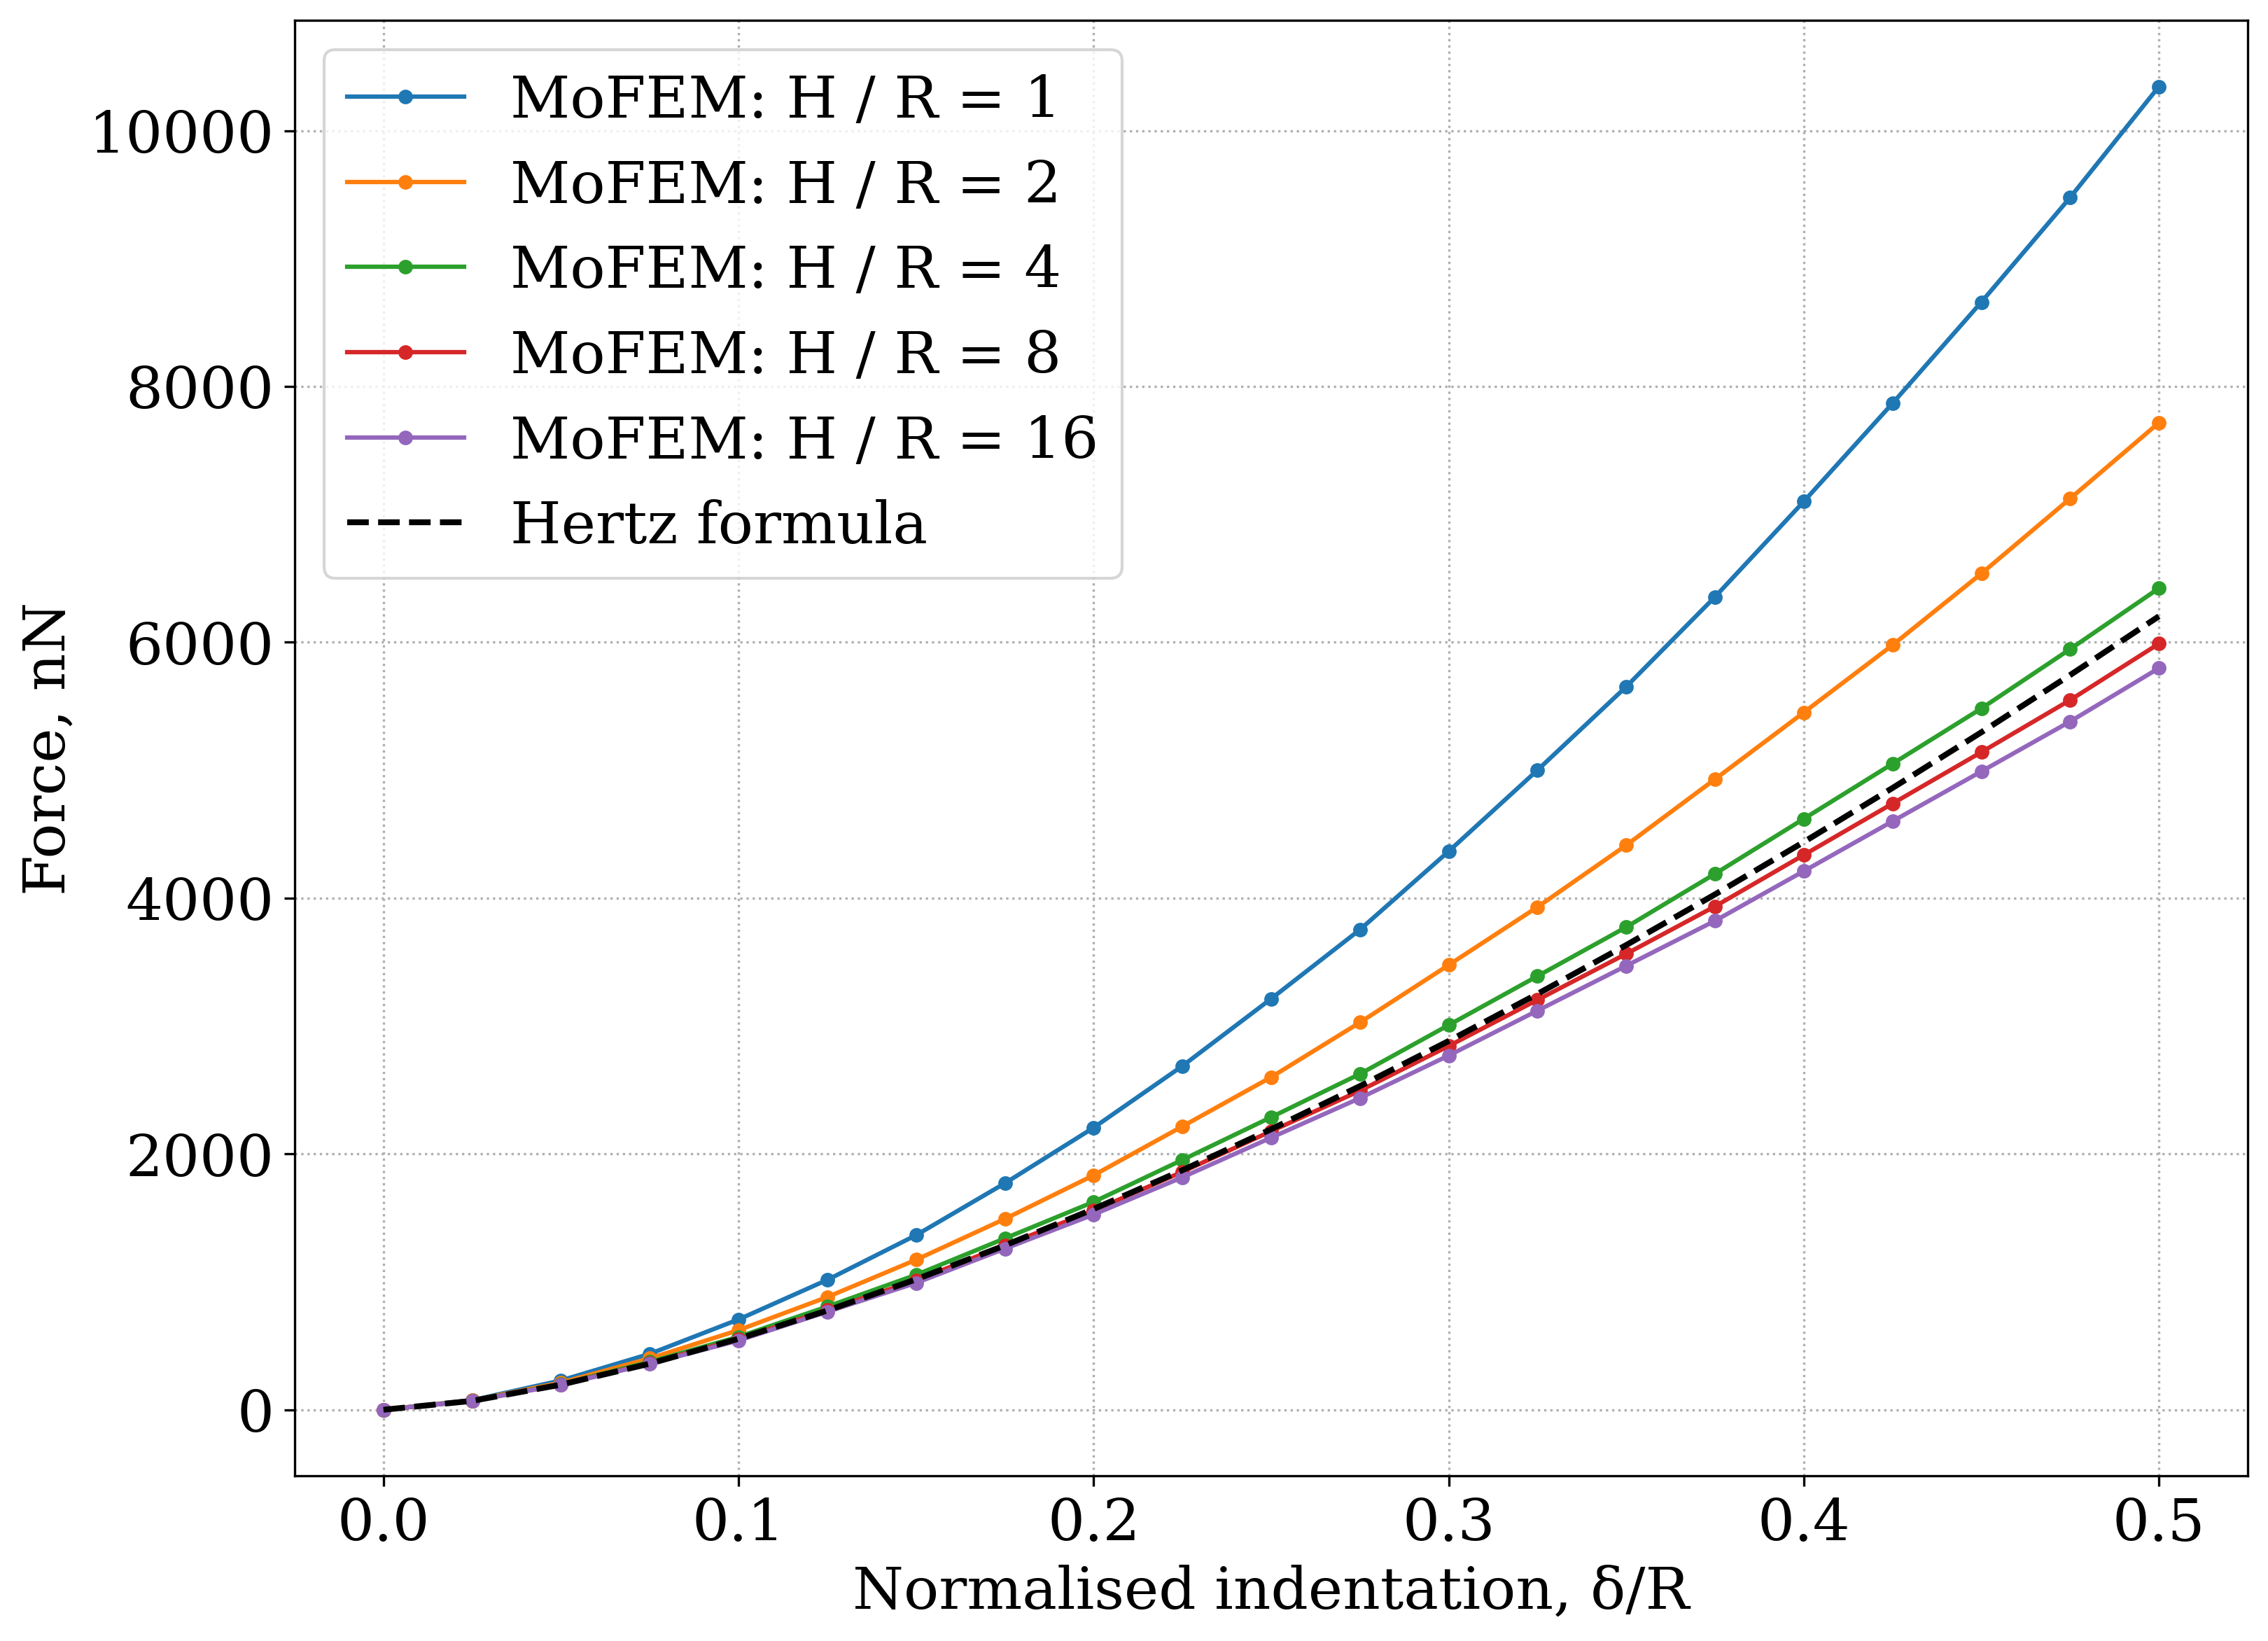

In [23]:
for elem_num, indent, force in zip(height_mult_list, indent_list, force_list):
    plt.plot(indent / params.indenter_radius, force, marker='o', ms=4, lw=1.5, label="MoFEM: H / R = {}".format(elem_num))
    
plt.plot(indent/params.indenter_radius, hertz_press(indent, params), c='k', ls='--', label="Hertz formula", lw=2)

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")